<span style="color:#333333; font-size:24px; font-weight:bold"> Analysis by <a href=https://github.com/cyterat style="color:#00b2b7;">cyterat</a></span>

<img src="https://pwimages-a.akamaihd.net/arc/6d/07/6d070b0efab67dfa6cee67e718653c271430891855.png"></img>

# Important Notice
**The original data analysis contained Personal Identifiable Information (PII).**

**The report containing the analysis summary and visualizations was done separately.**

**The list below shows changes made after the analysis originaly took place, to share the notebook publicly (github & portfolio website):**
- Removed guild name
- Removed guild logo
- Added function masking character names and account names
- Added function masking custom guild ranks

**Unrelated to PII changes:**
- Changed headers
- Changed some code to support current (3.12) Python version

In [1]:
# THIS FUNCITON WAS CREATED TO MASK SENSITIVE INFORMATION, ALLOWING TO SHARE THIS NOTEBOOK PUBLICLY
def mask_column(column):
    """
    This function replaces and reorders characters in a column 
    using the existing set of characters to mask sensitive data.

    Parameters:
        - column (pd.Series): DataFrame column to mask sensitive data

    Returns:
        - pd.Series: masked column
    """
    column = pd.Series(column)

    def shuffle_string(text):
        return ''.join([np.random.choice(list(text)) for _ in range(len(text))])

    ref = {}
    for i,e in enumerate(column.unique()):
        ref[column.unique()[i]] = shuffle_string(column.unique()[i])

    masked_column = pd.Series(column.map(ref))
    return masked_column

In [2]:
import json
import os

path = os.path.join('data','guild-ranks.json')

with open(path) as f:
    ranks = json.load(f)

# THIS FUNCITON WAS CREATED TO MASK SENSITIVE INFORMATION, ALLOWING TO SHARE THIS NOTEBOOK PUBLICLY
def mask_guild_rank(column):
    """
    This function replaces and reorders rank in a column 
    with their numerical representation where rank 1 is the lowest,
    to mask sensitive data.

    Parameters:
        - column (pd.Series): DataFrame column to mask sensitive data

    Returns:
        - pd.Series: masked column
    """
    return column.map(ranks)

# Initial Data Analysis (IDA)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
from datetime import datetime
import os

In [5]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)

In [6]:
nw_palette = sns.color_palette("blend:#ffc3a6,#FA9455,#F56504,#CC5404,#A44403,#7B3303,#522202", n_colors=9)
nw_palette

[(1.0, 0.7647058823529411, 0.6509803921568628),
 (0.9852364475201845, 0.625928489042676, 0.41181084198385237),
 (0.970472895040369, 0.4871510957324106, 0.17264129181084198),
 (0.9191695501730104, 0.37882352941176467, 0.01568627450980392),
 (0.7981545559400232, 0.3286735870818916, 0.0156401384083045),
 (0.6800461361014994, 0.28143021914648214, 0.012687427912341407),
 (0.5599077277970012, 0.232156862745098, 0.011764705882352941),
 (0.43884659746251437, 0.18196078431372548, 0.010703575547866204),
 (0.3215686274509804, 0.13333333333333333, 0.00784313725490196)]

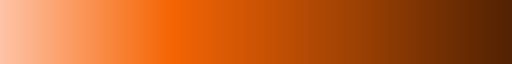

In [7]:
nw_cmap = sns.color_palette("blend:#ffc3a6,#FA9455,#F56504,#CC5404,#A44403,#7B3303,#522202", as_cmap=True)
nw_cmap

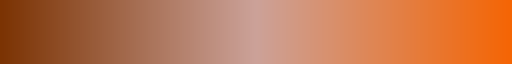

In [8]:
nw_cmap_heatmap = sns.color_palette("blend:#7B3303,#cca299,#f56504", as_cmap=True)
nw_cmap_heatmap

In [9]:
nw_cmap_heatmap_5 = sns.color_palette("blend:#7B3303,#cca299,#f56504",n_colors=5)
nw_cmap_heatmap_5

[(0.4823529411764706, 0.2, 0.011764705882352941),
 (0.6417993079584775, 0.4185005767012687, 0.3070357554786621),
 (0.8006305267204922, 0.6343560169165705, 0.5977085736255286),
 (0.8813379469434833, 0.5142791234140714, 0.30440599769319493),
 (0.9607843137254902, 0.396078431372549, 0.01568627450980392)]

In [10]:
nw_clr_single = '#f56504'
nw_clr_single_greyed = '#cca299'

In [11]:
sns.color_palette("blend:#f56504,#cca299", n_colors=2)

[(0.9607843137254902, 0.396078431372549, 0.01568627450980392),
 (0.8, 0.6352941176470588, 0.6)]

## Data Extraction & Cleaning

* Export members records with **/ExportGuildMemberList guild-member-list-281221.csv** command
<br></br>
* **/ExportGuildDonationLog** -- exports coffer donations
<br></br>
* default export directory *C:\Program Files (x86)\Steam\steamapps\common\Cryptic Studios\Neverwinter\Live\guild-member-list-281221.csv*

In [12]:
os.listdir('data')

['guild-member-list-281221-OUT.csv', 'guild-ranks.json']

In [13]:
file = os.path.join('data','guild-member-list-281221-OUT.csv')

In [14]:
pd.read_csv(file).shape

(334, 8)

In [15]:
_tmp = pd.read_csv(file)
_tmp.shape, _tmp.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Character Name      334 non-null    object
 1   Account Handle      334 non-null    object
 2   Level               334 non-null    int64 
 3   Class               334 non-null    object
 4   Guild Rank          334 non-null    object
 5   Contribution Total  334 non-null    int64 
 6   Join Date           334 non-null    object
 7   Last Active Date    334 non-null    object
dtypes: int64(2), object(6)
memory usage: 126.6 KB


((334, 8), None)

<Axes: >

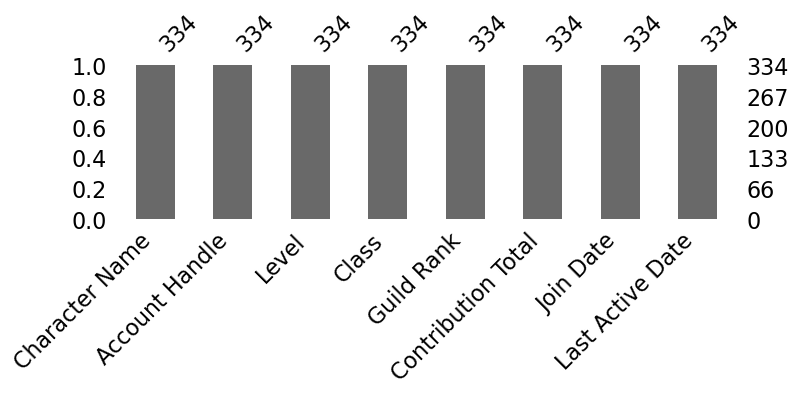

In [16]:
# Missing values visualization
missingno.bar(_tmp, figsize=(8,2))

In [17]:
# OUTPUT HIDDEN FOR CONFIDENTIALITY PURPOSES
_tmp.head(1);

In [18]:
del _tmp

### Variables description

- **Character Name** -- not unique - Name of the in-game character;
- **Account Handle** -- unique - Game account, can have multiple characters on it;
- **Level** -- 1-20 (nominal) -- Character level. Can be dropped, since guild is endgame focused, i.e. lvl 20 accounts only;
- **Class** -- 9 classes (cat. nominal) -- Character class (each has 2 subclases/roles, not provided in original file);
- **Guild Rank** -- 7 ranks (cat. ordinal) -- Character rank within guild. 1 = lowest rank. Single account might have characters with differrent ranks, (guild officer mistake) therefore max rank of character tied to account should be used;
- **Contribution Total** -- (num. discrete) -- Total contribution (donation) to guild coffer per character;
- **Join Date** -- datetime - Date and time a character accepted an invitation to guild. Some players might leave and get reinvited for various reasons, so this variable not reliable;
- **Last Active Date** -- datetime -- Last time a character logged into the game;

In [19]:
custom_date_parser = lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p")

df_raw = pd.read_csv(
    file,
    usecols=[0,1,3,4,5,7],
    converters={
        'Last Active Date': custom_date_parser
    }
)

# MASKED FOR CONFIDENTIALITY PURPOSES
df_raw['Character Name'] = mask_column(df_raw['Character Name'])
df_raw['Account Handle'] = mask_column(df_raw['Account Handle'])
df_raw['Guild Rank'] = mask_guild_rank(df_raw['Guild Rank'])

df_raw.head()

Character Name  Account Handle      Class  Guild Rank  Contribution Total  \
0          oSwowo  @@2@2#73ncr3o@      Rogue           6              485165   
1   RrRdaekereRRa     ni49an@n9@n     Cleric           4              425840   
2          eBDrBr    ome@1@9eram6  Barbarian           5              353118   
3  an anr'V aaEnk        @roo@s@b      Rogue           5              230163   
4     crcriritHrr    hiyieeeih@eh    Fighter           7              191713   

     Last Active Date  
0 2021-12-28 09:50:03  
1 2021-12-27 09:16:11  
2 2021-12-28 10:38:05  
3 2021-12-23 11:53:50  
4 2021-09-29 05:00:40

In [20]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_raw, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
df_raw.columns = ['character','account','character_class','guild_rank','contribution','last_active_date']
df_raw.head(1)

character         account character_class  guild_rank  contribution  \
0    oSwowo  @@2@2#73ncr3o@           Rogue           6        485165   

     last_active_date  
0 2021-12-28 09:50:03

In [22]:
df_raw[df_raw == ''].count()

character           0
account             0
character_class     0
guild_rank          0
contribution        0
last_active_date    0
dtype: int64

### Additional transformations

Based on the last active date, another piece of information can be extracted, number of **inactive days**. 

In [23]:
_date = file.split('-')[-2]
_date

'281221'

In [24]:
# +1 day start from the next day
file_date = pd.to_datetime(_date) + pd.Timedelta(days=1)
file_date

Timestamp('2021-12-29 00:00:00')

In [25]:
df_raw['days_inactive'] = (file_date - df_raw['last_active_date']).dt.days

df_raw

character         account character_class  guild_rank  \
0              oSwowo  @@2@2#73ncr3o@           Rogue           6   
1       RrRdaekereRRa     ni49an@n9@n          Cleric           4   
2              eBDrBr    ome@1@9eram6       Barbarian           5   
3      an anr'V aaEnk        @roo@s@b           Rogue           5   
4         crcriritHrr    hiyieeeih@eh         Fighter           7   
..                ...             ...             ...         ...   
329  _uD_Gateeiaeattu        7@tp@an@       Barbarian           1   
330            rinArr    1@la#@ee8@ll          Wizard           4   
331             yiKai          e@@1ea         Paladin           5   
332           lMMeleh      00i0ik0ii0          Cleric           3   
333           hkuPPac      00i0ik0ii0            Bard           3   

     contribution    last_active_date  days_inactive  
0          485165 2021-12-28 09:50:03              0  
1          425840 2021-12-27 09:16:11              1  
2          353118 2021-12-28 10:38:05              0  
3          230163 2021-12-23 11:53:50              5  
4          191713 2021-09-29 05:00:40             90  
..            ...                 ...            ...  
329             0 2021-11-25 09:10:39             33  
330             0 2021-12-26 05:30:08              2  
331             0 2021-12-28 05:33:30              0  
332             0 2021-12-28 12:38:49              0  
333             0 2021-12-27 05:14:17              1  

[334 rows x 7 columns]

# Exploratory Data Analysis (EDA)

In [26]:
from scipy import stats
import matplotlib.pyplot as plt

## Overview

In [27]:
df_guild = df_raw.copy()
df_guild.head()

character         account character_class  guild_rank  contribution  \
0          oSwowo  @@2@2#73ncr3o@           Rogue           6        485165   
1   RrRdaekereRRa     ni49an@n9@n          Cleric           4        425840   
2          eBDrBr    ome@1@9eram6       Barbarian           5        353118   
3  an anr'V aaEnk        @roo@s@b           Rogue           5        230163   
4     crcriritHrr    hiyieeeih@eh         Fighter           7        191713   

     last_active_date  days_inactive  
0 2021-12-28 09:50:03              0  
1 2021-12-27 09:16:11              1  
2 2021-12-28 10:38:05              0  
3 2021-12-23 11:53:50              5  
4 2021-09-29 05:00:40             90

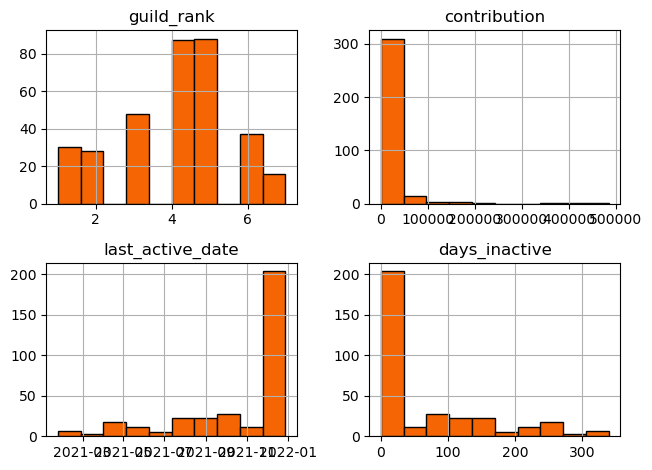

In [28]:
df_guild.hist(
    bins=10,
    layout=(-1,2),
    edgecolor="black",
    color=nw_clr_single
    )
plt.tight_layout()

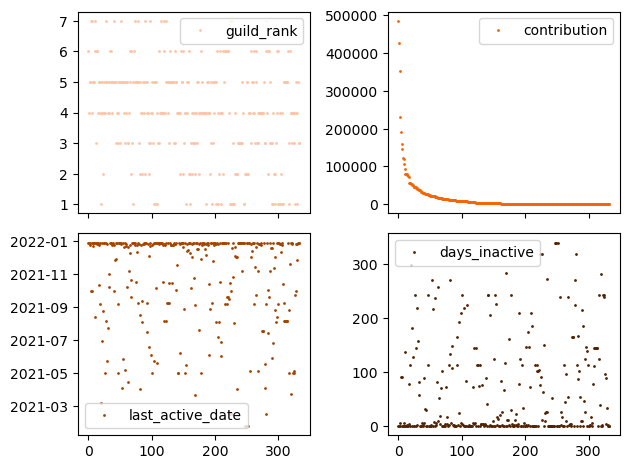

In [29]:
df_guild.plot(
    layout=(-1, 2),
    subplots=True,
    marker=".",
    markersize=2,
    lw=0,
    cmap=nw_cmap
)
plt.tight_layout()

In [30]:
df_guild.describe(percentiles=[.25, .5, .75, .9, .95, .99]).style.format(thousands=',', precision=0)

**From the quick overview above, we can see that:**
- Substantial amount, at least 25%, of characters haven't made any contributions as of today.
- Only around 1% of characters have extremly large total contribution, when compared to others.
- Roughly half of the character base in guild have less than 5 days of inactivity; i.e. approximately 50% of all characters can be seen online throughout a week.
- 1% of characters have not logged in (been used) for nearly a whole year.

## Accounts with Most Characters in the Guild

In [31]:
_acc_chars_count = (
    df_guild
    .groupby('account')
    .agg({'guild_rank':'max','character':'count'})
    .sort_values('character', ascending=False)
)

In [32]:
_acc_chars_count = (
    _acc_chars_count[_acc_chars_count['character'] > _acc_chars_count['character'].quantile(.9)]
    .rename(columns={'character':'characters'})
    .sort_values('guild_rank', ascending=True)
    .reset_index()
)
_acc_chars_count

account  guild_rank  characters
0       1#22o3222h1@r           3           9
1      pycs@epaspalse           3           8
2        3rg@doopg@#r           4          10
3      1l71jt@0@@@71e           4           8
4          m@aa@aemma           5          10
5            @roo@s@b           5           9
6              e@@1ea           5           8
7      @exe@@orprrpro           5           8
8           tpa6@uotu           5           8
9      @@2@2#73ncr3o@           6           9
10  hedxamtmedltxratx           6           8
11           uma@@a@@           7           7

In [33]:
# Find max characters within each guild_rank
max_characters = _acc_chars_count.groupby('guild_rank')['characters'].transform('max')

# Create color list
_bar_colors = [(0.0,0.0,0.0,0.0) if char == max_characters[i] else 'white' for i,char in enumerate(_acc_chars_count['characters'])]

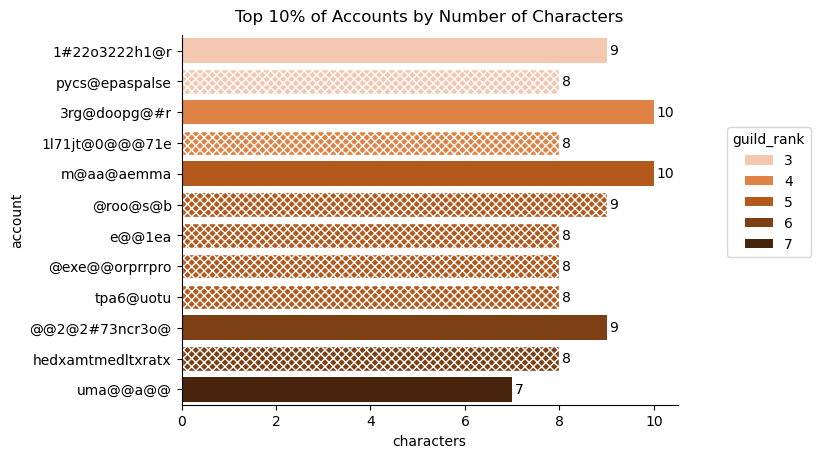

In [34]:
s = sns.barplot(
    data=_acc_chars_count,
    x='characters',
    y='account',
    hue='guild_rank',
    orient='h',
    palette=nw_cmap
)

for i,container in enumerate(s.containers):
    tmp_hue = _acc_chars_count.loc[_acc_chars_count['guild_rank']==container.get_label()]
    s.bar_label(container, labels=tmp_hue['characters'], padding=2, fmt='{:,.0f}')
    
for i,patch in enumerate(s.patches):
    if i < len(_bar_colors):
        patch.set_hatch('xxxx')
        patch.set_edgecolor(_bar_colors[i])

sns.move_legend(s, loc=(1.1, 0.4))

plt.title('Top 10% of Accounts by Number of Characters', pad=10)
sns.despine()

## Distribution of Classes in the Guild

In [35]:
_class_count = df_guild['character_class'].value_counts().reset_index()
_class_count

character_class  count
0          Cleric     51
1          Wizard     46
2           Rogue     44
3       Barbarian     41
4         Warlock     38
5         Paladin     37
6         Fighter     35
7          Ranger     32
8            Bard     10

In [36]:
_colors = {}
for i,c in enumerate(_class_count['character_class']):
    if _class_count.loc[i,'count']==_class_count['count'].max() or _class_count.loc[i,'count']==_class_count['count'].min():
        _colors[c]=nw_clr_single
    else:
        _colors[c]=nw_clr_single_greyed

_colors

{'Cleric': '#f56504',
 'Wizard': '#cca299',
 'Rogue': '#cca299',
 'Barbarian': '#cca299',
 'Warlock': '#cca299',
 'Paladin': '#cca299',
 'Fighter': '#cca299',
 'Ranger': '#cca299',
 'Bard': '#f56504'}

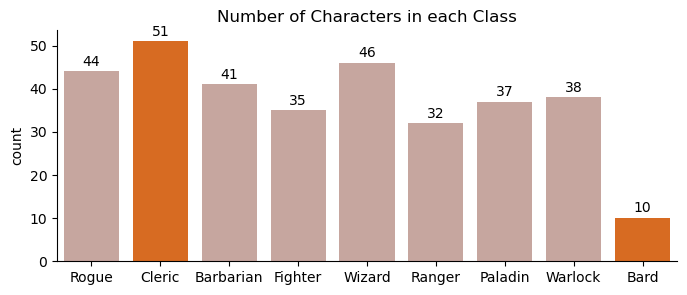

In [37]:
plt.figure(figsize=(8, 3))
s = sns.countplot(x='character_class', data=df_guild, palette=_colors)

for container in s.containers:
    tmp_hue = _class_count.loc[_class_count['character_class']==container.get_label()]
    s.bar_label(container, labels=tmp_hue['count'], padding=2, fmt='{:,.0f}')
    
plt.title('Number of Characters in each Class');
plt.xlabel('')
sns.despine()

## Accounts with the Largest Total Contribution

In [38]:
_acc_contrib = df_guild.groupby(['account']).agg({'guild_rank':'max','contribution':'sum'}).sort_values('contribution',ascending=False)

_acc_contrib = _acc_contrib[_acc_contrib['contribution'] > _acc_contrib['contribution'].quantile(.9)].reset_index()
_acc_contrib

account  guild_rank  contribution
0       ni49an@n9@n           4        572554
1    @@2@2#73ncr3o@           6        509316
2          @roo@s@b           5        374422
3      ome@1@9eram6           5        353118
4      hiyieeeih@eh           7        246533
5             y@@uu           7        186810
6         tpa6@uotu           5        158234
7          uma@@a@@           7        156128
8        llasjlooj@           5        122941
9      nii@tttdhgtm           5        121769
10       m@aa@aemma           5        109053
11         BlulBbll           5        105706
12     3rg@doopg@#r           4         98920
13  rs6aiacen@isi@a           6         95874

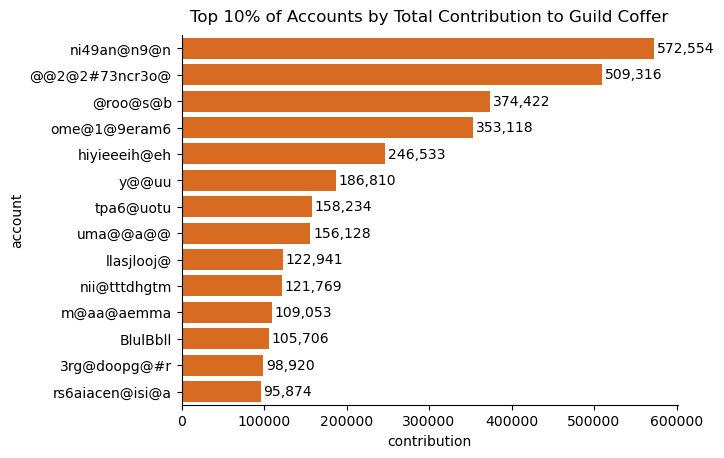

In [39]:
s = sns.barplot(
    data=_acc_contrib,
    x='contribution',
    y='account',
    orient='h',
    color=nw_clr_single
)
s.bar_label(s.containers[0],padding=2, fmt='{:,.0f}')
plt.title('Top 10% of Accounts by Total Contribution to Guild Coffer', pad=10)
sns.despine()

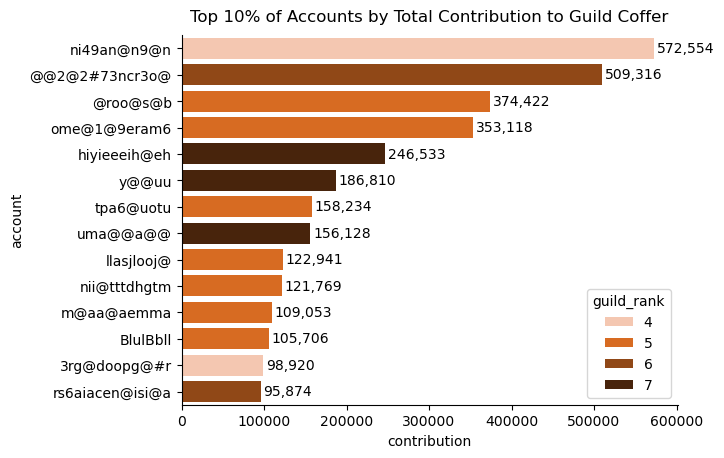

In [40]:
s = sns.barplot(
    data=_acc_contrib,
    x='contribution',
    y='account',
    hue='guild_rank',
    orient='h',
    palette=nw_cmap
)

for container in s.containers:
    tmp_hue = _acc_contrib.loc[_acc_contrib['guild_rank']==container.get_label()]
    s.bar_label(container, labels=tmp_hue['contribution'], padding=2, fmt='{:,.0f}')
    
plt.title('Top 10% of Accounts by Total Contribution to Guild Coffer', pad=10)
sns.despine()

## New Members with Non-Zero Contribution

- **New Members** = accounts with the maximum character Guild Rank equal to 1 

In [41]:
_new_member = (df_guild.groupby('account')['guild_rank'].max()==1).reset_index()
_new_member = (_new_member[_new_member['guild_rank']==True]['account']).values
_new_member

array(['#79#lg7g9@sggi9dn', '#@9@0xn99sx33', '#co0oroood#dl#l',
       '#t@ia823h@m3i2aatp3', '41c1488r41om11o@0', '6x@##8x@amo60w#',
       '72sa@#ns@8179nanna', '7@tp@an@', '9t7efww35@@ftwi9',
       '@cainu@ooaig1o@a', '@nun@u', '@tugblebhea@h@kb', 'a4#nzuaunkiik',
       'bhu5uku@hb5#', 'e@eye@fatntfrtee', 'gsoh@s@m', 'i5so9d0#@md0ns7',
       'knu@2n2e@or6kko6e', 'leel9u9e9ls', 'lgrllrgeoknle@',
       'm#1m515mz50@5', 'taa9dct@catl'], dtype=object)

In [42]:
_new_contrib = (
    df_guild[df_guild['account']
    .isin(_new_member)]
    .groupby('account')['contribution']
    .sum()
    .sort_values(ascending=False)
)
_new_contrib = _new_contrib[_new_contrib != 0].reset_index()
_new_contrib

account  contribution
0       taa9dct@catl         53966
1      #@9@0xn99sx33         15098
2    i5so9d0#@md0ns7          7580
3    #co0oroood#dl#l          7479
4      m#1m515mz50@5          2683
5   e@eye@fatntfrtee          2249
6       bhu5uku@hb5#           616
7  #79#lg7g9@sggi9dn           190
8   @tugblebhea@h@kb           144

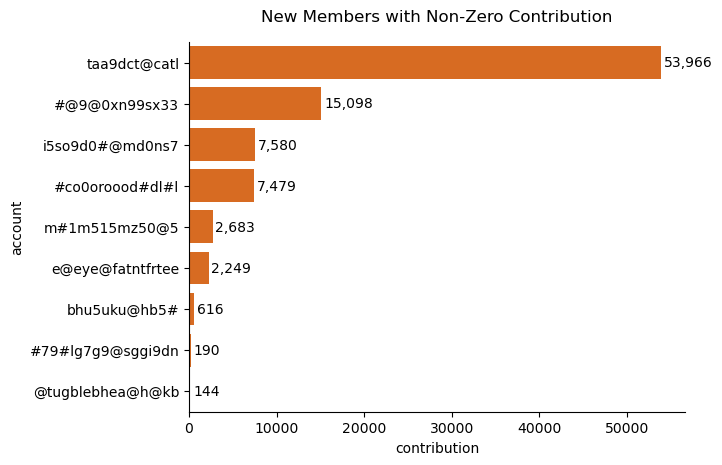

In [43]:
s = sns.barplot(data=_new_contrib, x='contribution', y='account', color=nw_clr_single)
s.bar_label(s.containers[0],padding=2, fmt='{:,.0f}')
plt.title('New Members with Non-Zero Contribution', pad=15)
sns.despine()

In [44]:
a = pd.DataFrame({'account':_new_member, 'contribution':'zero'})
b = pd.DataFrame({'account':_new_contrib['account'].values, 'contribution':'non-zero'})

In [45]:
_new_contrib_poportions = pd.concat([a,b])
_new_contrib_poportions.sample(5)

account contribution
4    41c1488r41om11o@0         zero
11    @tugblebhea@h@kb         zero
15            gsoh@s@m         zero
5      6x@##8x@amo60w#         zero
6   72sa@#ns@8179nanna         zero

In [46]:
_new_contrib_poportions= (
    _new_contrib_poportions
    .groupby('contribution')
    .count()
    .sort_values(by='contribution',ascending=False)
    .reset_index()
)
_new_contrib_poportions

contribution  account
0         zero       22
1     non-zero        9

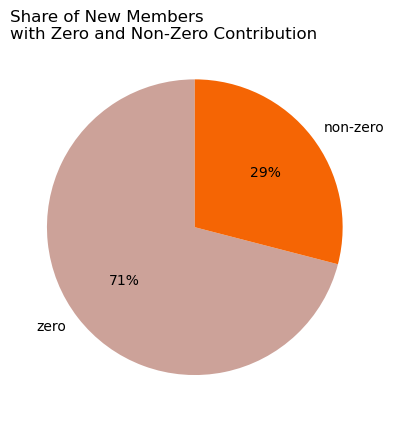

In [47]:
plt.pie(
    _new_contrib_poportions['account'],
    startangle=90,
    autopct="%.0f%%",
    colors=[nw_clr_single_greyed,nw_clr_single],
    labels=_new_contrib_poportions['contribution'],
)

plt.title('Share of New Members\nwith Zero and Non-Zero Contribution', pad=0, loc='left');

## Old Members with low Contribution

- **Old Members** = accounts with maximum character Guild Rank equal to 4 
- **low** (for old members only) = equal to or lower than median of the Guild Rank 1 players total Contribution

In [48]:
_old_member = (df_guild.groupby('account')['guild_rank'].max()>=4).reset_index()
_old_member = (_old_member[_old_member['guild_rank']==True]['account']).values
_old_member

array(['#i#5nas#6n6t5', '#t@sso3@0@oo', '0a9dcdaa09@ca#',
       '0nei0@900#oc92c', '1@la#@ee8@ll', '1l71jt@0@@@71e',
       '3rg@doopg@#r', '7e82#6aegese6e', '9171onby97@9e7nyoen',
       '@6soo24#i78ojj', '@@2@2#73ncr3o@', '@@@hldbhlkh', '@@el@ccdl',
       '@emnnn3n8#8nm', '@exe@@orprrpro', '@ikeelkek', '@oBb7bB9l@lb#@',
       '@roo@s@b', 'BlulBbll', 'a#0l00ia#@2l44', 'a@berrrdbann@',
       'aaoorga@', 'ai2piza@i', 'akkkyckr', 'anamnnunmuman',
       'aunnnaceelcce', 'azz0a2@2z', 'cagga4@ckkk4a@', 'chh7ssisi',
       'd@1d@dre', 'e@@1ea', 'eddnieadn@na', 'elhw@hhheei',
       'emwoellc@1oo9l9ee', 'etii#1t@e60de#6', 'g2aol#57og7n2a3w2gd',
       'h@rr@th@9000', 'hedxamtmedltxratx', 'hiyieeeih@eh', 'iasgp455ggg',
       'izl@iszsl@lil', 'kheyhny@ej', 'llasjlooj@', 'llecmddmiiarppee',
       'm@aa@aemma', 'mesmtrmrwmrewae', 'mhabchahhbn', 'n@a7nn',
       'nfndwndf6f', 'nh#2y3n#2on@', 'ni49an@n9@n', 'nii@tttdhgtm',
       'ns@ssolsu', 'o70gl3#o77077#', 'ocproopepr', 'ome@1@9eram6',
 

In [178]:
# Aggregate accounts that are considered 'old'
_old_contrib = (
    df_guild[df_guild['account']
    .isin(_old_member)]
    .groupby('account')
    .agg({'guild_rank':'max', 'contribution':'sum'})
    .reset_index()
)
_old_contrib

account guild_rank  contribution
0     #i#5nas#6n6t5          5         56408
1      #t@sso3@0@oo          4         38683
2    0a9dcdaa09@ca#          4         19452
3   0nei0@900#oc92c          4          1130
4      1@la#@ee8@ll          4          9370
..              ...        ...           ...
63      u@bell@bndl          5         26569
64         uma@@a@@          7        156128
65  xae@rxexmeeextx          4         11325
66            y@@uu          7        186810
67       ygyogoyylz          5         56960

[68 rows x 3 columns]

In [179]:
# Filter old accounts that have low-to-none contribution
_old_contrib_low = (
    _old_contrib[_old_contrib['contribution'] <= _new_contrib['contribution'].median()]
    .sort_values('guild_rank',ascending=False)
    .reset_index(drop=True)
)
_old_contrib_low

account guild_rank  contribution
0           kheyhny@ej          5             0
1            ns@ssolsu          5             0
2          r@nls@aeaso          5           900
3       ssgimmegd@tdmt          5          1534
4      0nei0@900#oc92c          4          1130
5            ai2piza@i          4           972
6  g2aol#57og7n2a3w2gd          4          1942
7       o70gl3#o77077#          4             0
8        rneer1s1rt3ir          4           624

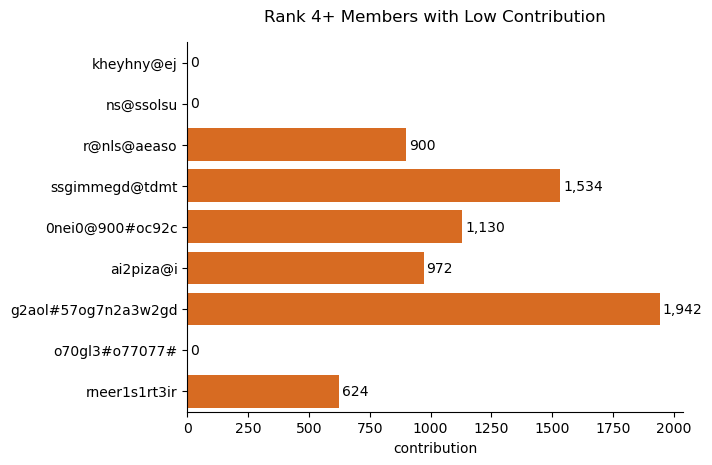

In [180]:
s = sns.barplot(
    data=_old_contrib_low,
    x='contribution',
    y='account',
    orient='h',
    color=nw_clr_single
)

s.bar_label(s.containers[0], padding=2, fmt='{:,.0f}')

plt.title('Rank 4+ Members with Low Contribution', pad=15)
s.set_ylabel('')
sns.despine()

## Contribution (Coffer Donations)

In [52]:
df_guild['account'].nunique()

136

In [53]:
df_guild['contribution'].describe()

count      334.00000
mean     15624.63174
std      47331.59043
min          0.00000
25%          0.00000
50%       1875.00000
75%      11080.00000
max     485165.00000
Name: contribution, dtype: float64

In [54]:
df_guild['contribution'].describe([.75,.80,.85,.90,.95,.99,.999])

count      334.00000
mean     15624.63174
std      47331.59043
min          0.00000
50%       1875.00000
75%      11080.00000
80%      16891.60000
85%      23016.60000
90%      37609.70000
95%      61466.90000
99%     217474.50000
99.9%   465409.77500
max     485165.00000
Name: contribution, dtype: float64

In [55]:
_contrib_outliers = df_guild.groupby('account')['contribution'].sum().reset_index()
_contrib_outliers_acc = _contrib_outliers[_contrib_outliers['contribution'] >= _contrib_outliers['contribution'].quantile(.95)]['account'].values
_contrib_outliers_acc

array(['@@2@2#73ncr3o@', '@roo@s@b', 'hiyieeeih@eh', 'ni49an@n9@n',
       'ome@1@9eram6', 'tpa6@uotu', 'y@@uu'], dtype=object)

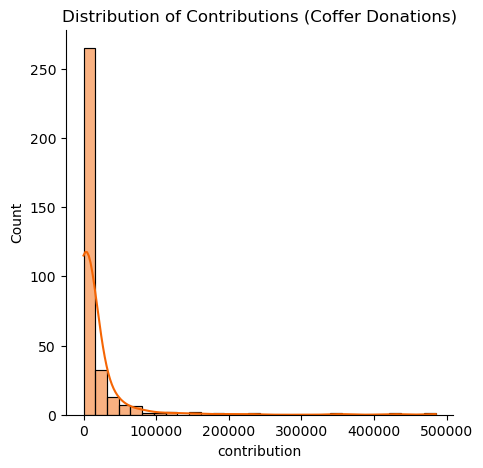

In [56]:
plt.figure(figsize=(5, 5))
sns.histplot(df_guild['contribution'], bins=30, kde=True, color=nw_clr_single)
plt.title('Distribution of Contributions (Coffer Donations)')
sns.despine()

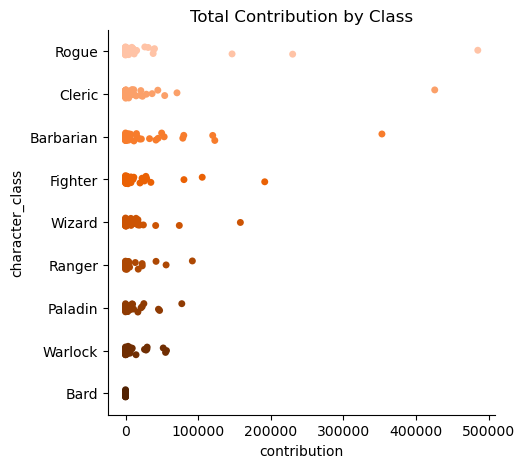

In [57]:
plt.figure(figsize=(5, 5))
sns.stripplot(y='character_class', x='contribution', data=df_guild, hue='character_class', jitter=True, palette=nw_palette)
plt.title('Total Contribution by Class')
sns.despine()

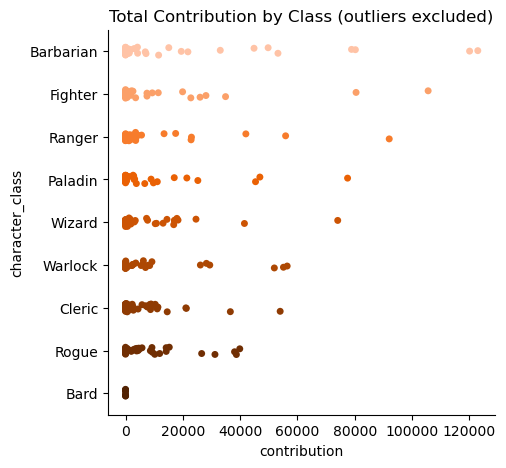

In [58]:
plt.figure(figsize=(5, 5))
sns.stripplot(y='character_class', x='contribution', data=df_guild[~df_guild['account'].isin(_contrib_outliers_acc)], hue='character_class', jitter=True, palette=nw_palette)
plt.title('Total Contribution by Class (outliers excluded)')
sns.despine()

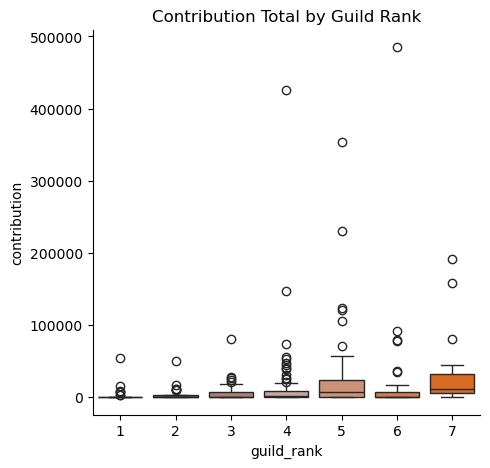

In [59]:
plt.figure(figsize=(5, 5))
sns.boxplot(
    x='guild_rank',
    y='contribution',
    data=df_guild,
    hue='guild_rank',
    legend=False,
    palette=nw_cmap_heatmap
)
plt.title('Contribution Total by Guild Rank')
sns.despine()

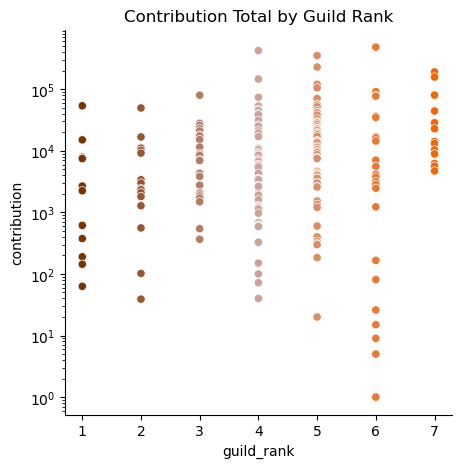

In [60]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x='guild_rank',
    y='contribution',
    data=df_guild,
    hue='guild_rank',
    legend=False,
    palette=nw_cmap_heatmap
)
plt.yscale('log')
plt.title('Contribution Total by Guild Rank')
sns.despine()

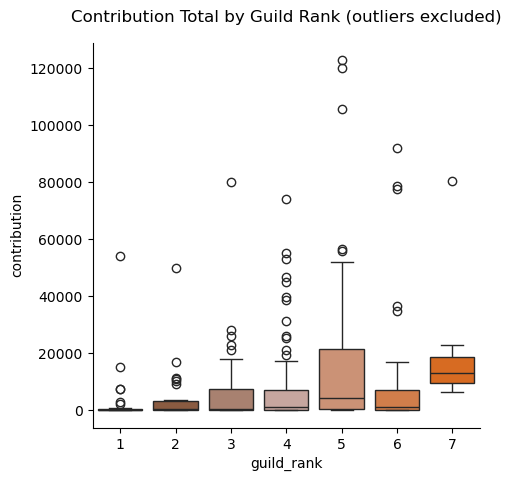

In [61]:
plt.figure(figsize=(5, 5))
sns.boxplot(
    x='guild_rank',
    y='contribution',
    data=df_guild[~df_guild['account'].isin(_contrib_outliers_acc)],
    hue='guild_rank',
    legend=False,
    palette=nw_cmap_heatmap
)
plt.title('Contribution Total by Guild Rank (outliers excluded)', pad=15)
sns.despine()

In [62]:
_var_contrib = df_guild.groupby(['guild_rank']).agg({'contribution':stats.iqr}).rename(columns={'contribution':'iqr'}).reset_index()
_var_contrib

guild_rank         iqr
0           1   556.00000
1           2  3091.25000
2           3  7463.00000
3           4  7913.00000
4           5 22635.25000
5           6  7067.00000
6           7 27184.50000

In [63]:
_rank_contrib = (df_guild
 .groupby(['account'])
 .agg({
     'guild_rank':'max',
     'contribution':'sum'
 })
 .sort_values('guild_rank', ascending=False)
 .reset_index()
).groupby('guild_rank')['contribution'].sum().reset_index()

_rank_contrib

guild_rank  contribution
0           1         90005
1           2        124196
2           3        307099
3           4       1207003
4           5       2009587
5           6        891266
6           7        589471

In [64]:
_rank_contrib = _rank_contrib.merge(_var_contrib, on='guild_rank')
_rank_contrib

guild_rank  contribution         iqr
0           1         90005   556.00000
1           2        124196  3091.25000
2           3        307099  7463.00000
3           4       1207003  7913.00000
4           5       2009587 22635.25000
5           6        891266  7067.00000
6           7        589471 27184.50000

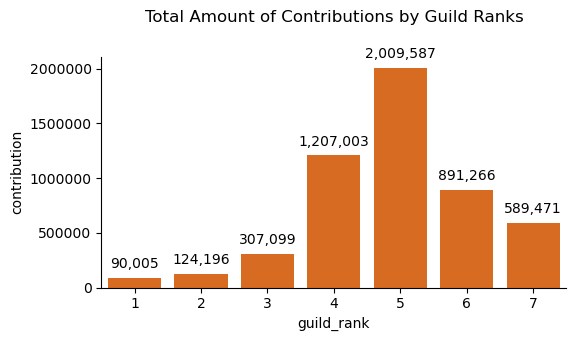

In [65]:
plt.figure(figsize=(6, 3))
s = sns.barplot(
    x='guild_rank',
    y='contribution',
    data=_rank_contrib,
    color=nw_clr_single
)
s.bar_label(s.containers[0], fmt='{:,.0f}', padding=5)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Amount of Contributions by Guild Ranks', pad=25)
sns.despine()

In [66]:
_colors = {}
for i,c in enumerate(_rank_contrib['guild_rank']):
    if _rank_contrib.loc[i,'contribution']==_rank_contrib['contribution'].max():
        _colors[c]=nw_clr_single
    else:
        _colors[c]=nw_clr_single_greyed

_colors

{1: '#cca299',
 2: '#cca299',
 3: '#cca299',
 4: '#cca299',
 5: '#f56504',
 6: '#cca299',
 7: '#cca299'}

In [67]:
import matplotlib.ticker as ticker

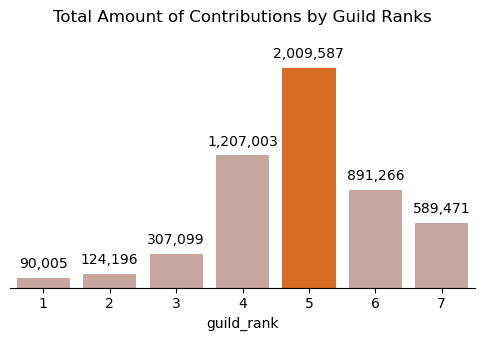

In [68]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    ax=ax,
    x='guild_rank',
    y='contribution',
    data=_rank_contrib,
    hue='guild_rank',
    palette=_colors,
    legend=False
)

for container in s.containers:
    tmp_hue = _rank_contrib.loc[_rank_contrib['guild_rank']==container.get_label()]
    ax.bar_label(container, labels=tmp_hue['contribution'], padding=5, fmt='{:,.0f}')

ax.set(ylabel=None, yticks=[])

plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Amount of Contributions by Guild Ranks', pad=25)
sns.despine(left=True)

## Inactive Accounts

In [69]:
_acc_inact = (
    df_guild
    .groupby('account')
    .agg({
        'guild_rank':'max',
        'days_inactive':'min'
    })
    .sort_values(
        by=['guild_rank','days_inactive'], 
        ascending=[True, False]
    )
)
_acc_inact = _acc_inact[_acc_inact['days_inactive'] > _acc_inact['days_inactive'].quantile(.9)].reset_index()
_acc_inact

account  guild_rank  days_inactive
0           taa9dct@catl           1            297
1          m#1m515mz50@5           1            226
2        #co0oroood#dl#l           1            223
3        6x@##8x@amo60w#           1            214
4   otmxeix3#6nn@o3@kin3           2            271
5      a1i1o1oc3a#n3nc1a           2            270
6              spparosra           2            205
7                ttWhhWt           3            282
8             u6zlll6l@4           3            257
9              u@an8m8@m           3            238
10     ci#20c3c@@paccouu           3            224
11        @oBb7bB9l@lb#@           4            208
12        cagga4@ckkk4a@           5            236
13           mhabchahhbn           5            216

<Axes: >

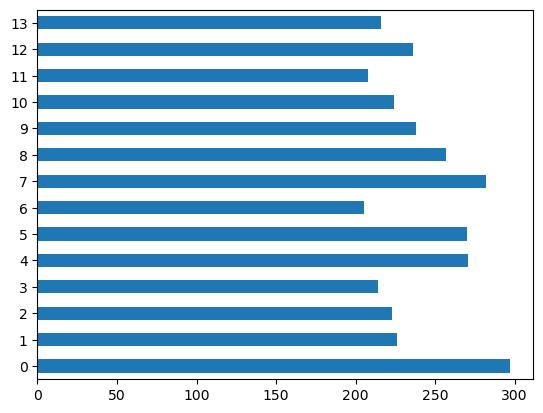

In [70]:
_acc_inact['days_inactive'].plot(kind='barh')

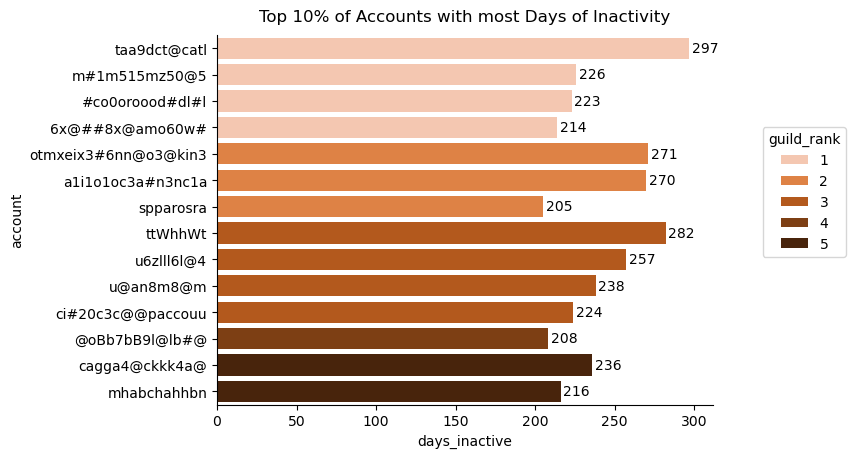

In [71]:
s = sns.barplot(
    data=_acc_inact,
    x='days_inactive',
    y='account',
    orient='h',
    hue='guild_rank',
    palette=nw_cmap
)

sns.move_legend(s,loc=(1.1, 0.4))

for container in s.containers:
    tmp_hue = _acc_inact.loc[_acc_inact['guild_rank']==container.get_label()]
    s.bar_label(container, labels=tmp_hue['days_inactive'], padding=2, fmt='{:,.0f}')
    
plt.title('Top 10% of Accounts with most Days of Inactivity', pad=10)
sns.despine()

## Popular Classes

My **Definition of Popular Class**

A "Popular Class" is determined by its activity and contribution within the game, specifically by the **popularity score**, which is calculated for each class by combining three normalized factors:
- number of characters
- contribution
- days of inactivity

The normalized popularity score I used here is calculated using the following two-step process:

$$
\begin{aligned}
\text{PS}_{c,r} &= 0.45 \cdot \frac{n_{c,r}}{N_r} + 0.45 \cdot \text{norm}_r(C_{c,r}) - 0.1 \cdot \text{norm}_r(I_{c,r}) \\[10pt]
\text{NPS}_{c,r} &= \frac{\text{PS}_{c,r} - \min_c(\text{PS}_{c,r})}{\max_c(\text{PS}_{c,r}) - \min_c(\text{PS}_{c,r})}
\end{aligned}
$$

- $\text{PS}_{c,r}$ is the Popularity Score
- $\text{NPS}_{c,r}$ is the Normalized Popularity Score for class $c$ in rank $r$
- $n_{c,r}$ is the number of characters of class $c$ in rank $r$
- $N_r$ is the total number of characters in rank $r$
- $C_{c,r}$ is the contribution of class $c$ in rank $r$
- $I_{c,r}$ is the inactivity (days inactive) of class $c$ in rank $r$
- $\text{norm}_r()$ is the normalization function applied within rank $r$

*P.S. The inactivity penalty was first set to 0.2, but then i decided it was too harsh, so 10% was chosen instead. Short-term inactivity shouldn't heavily penalize otherwise active and contributing classes.*

Additional Info: The process gives equal positive weight (45% ~40%~ each) to the number of characters and their contribution, while applying a negative weight (10% ~20%~) to inactivity. 

This creates a balanced metric where classes with more active and contributing members score higher, while those with longer periods of inactivity are penalized. The score is normalized within each guild rank, allowing for fair comparisons across different ranks and character classes.

In [72]:
_popular_classes = (
    df_guild
    .groupby(['guild_rank','character_class'])
    .agg({
        'days_inactive':lambda x: np.ceil(np.median(x)),
        'contribution':'median',
        'character':'count'
    })
    .rename(columns={'character':'characters'})
    .reset_index()
)
_popular_classes.head(10)

guild_rank character_class  days_inactive  contribution  characters
0           1       Barbarian       33.00000       0.00000           5
1           1            Bard        2.00000       0.00000           1
2           1          Cleric      129.00000     283.00000           6
3           1         Fighter      174.00000     144.00000           5
4           1         Paladin       38.00000       0.00000           2
5           1          Ranger       11.00000       0.00000           3
6           1           Rogue       77.00000       0.00000           3
7           1         Warlock        1.00000    1124.50000           2
8           1          Wizard      149.00000      63.00000           3
9           2       Barbarian      137.00000     956.50000           4

In [73]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

In [74]:
# Calculate the proportion of each class within its rank
_popular_classes['class_proportion'] = _popular_classes.groupby('guild_rank')['characters'].transform(lambda x: x / x.sum())

# Normalize contribution and days_inactive
_popular_classes['norm_contribution'] = _popular_classes.groupby('guild_rank')['contribution'].transform(normalize)
_popular_classes['norm_days_inactive'] = _popular_classes.groupby('guild_rank')['days_inactive'].transform(normalize)

_popular_classes.head(1)

guild_rank character_class  days_inactive  contribution  characters  \
0           1       Barbarian       33.00000       0.00000           5   

   class_proportion  norm_contribution  norm_days_inactive  
0           0.16667            0.00000             0.18497

In [75]:
# Calculate the popularity score
_popular_classes['popularity_score'] = (
    _popular_classes['class_proportion'] * 0.45 +
    _popular_classes['norm_contribution'] * 0.45 -
    _popular_classes['norm_days_inactive'] * 0.1
)

_popular_classes.head(1)

guild_rank character_class  days_inactive  contribution  characters  \
0           1       Barbarian       33.00000       0.00000           5   

   class_proportion  norm_contribution  norm_days_inactive  popularity_score  
0           0.16667            0.00000             0.18497           0.05650

In [76]:
# Normalize the popularity score within each rank
_popular_classes['normalized_popularity_score'] = _popular_classes.groupby('guild_rank')['popularity_score'].transform(normalize)
_popular_classes.head(1)

guild_rank character_class  days_inactive  contribution  characters  \
0           1       Barbarian       33.00000       0.00000           5   

   class_proportion  norm_contribution  norm_days_inactive  popularity_score  \
0           0.16667            0.00000             0.18497           0.05650   

   normalized_popularity_score  
0                      0.14503

### Visualization

In [77]:
NPS = _popular_classes.pivot(index='character_class', columns='guild_rank', values='normalized_popularity_score').fillna(0)
NPS

guild_rank            1       2       3       4       5       6       7
character_class                                                        
Barbarian       0.14503 0.10969 0.18832 0.34117 1.00000 1.00000 0.00000
Bard            0.06008 0.00000 0.09065 0.08800 0.00000 0.00000 0.00000
Cleric          0.29192 0.27066 0.00000 0.55801 0.16132 0.21306 0.28456
Fighter         0.09683 0.00000 1.00000 0.19393 0.25366 0.09171 1.00000
Paladin         0.04835 0.11651 0.16121 0.14692 0.15080 0.52708 0.15198
Ranger          0.11014 0.12552 0.49552 0.14203 0.30601 0.35202 0.24501
Rogue           0.03312 1.00000 0.24500 1.00000 0.13063 0.20310 0.00000
Warlock         1.00000 0.10717 0.47706 0.00000 0.53805 0.18900 0.09818
Wizard          0.00000 0.17575 0.09393 0.39348 0.26159 0.13467 0.16676

In [78]:
NPS.describe([.5,.75,.8,.9,.95,.99,.999])

guild_rank       1       2       3       4       5       6       7
count      9.00000 9.00000 9.00000 9.00000 9.00000 9.00000 9.00000
mean       0.19839 0.21170 0.30574 0.31817 0.31134 0.30118 0.21628
std        0.31237 0.30693 0.31031 0.30794 0.29777 0.30295 0.31236
min        0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
50%        0.09683 0.11651 0.18832 0.19393 0.25366 0.20310 0.15198
75%        0.14503 0.17575 0.47706 0.39348 0.30601 0.35202 0.24501
80%        0.20379 0.21372 0.48444 0.45929 0.39883 0.42204 0.26083
90%        0.43354 0.41653 0.59641 0.64641 0.63044 0.62167 0.42765
95%        0.71677 0.70826 0.79821 0.82320 0.81522 0.81083 0.71382
99%        0.94335 0.94165 0.95964 0.96464 0.96304 0.96217 0.94276
99.9%      0.99434 0.99417 0.99596 0.99646 0.99630 0.99622 0.99428
max        1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000

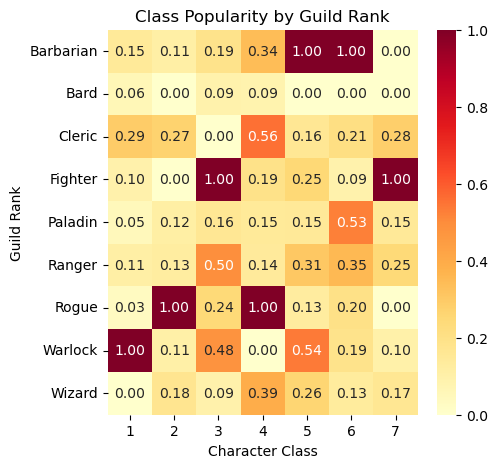

In [79]:
plt.figure(figsize=(5, 5))
sns.heatmap(NPS, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Class Popularity by Guild Rank')
plt.ylabel('Guild Rank')
plt.xlabel('Character Class')
plt.show()

In [80]:
high_popularity = 0.3
low_popularity = 0

In [81]:
labels_score = np.where(NPS >= high_popularity, "High",
                        np.where(NPS <= low_popularity, "Low", ""))
labels_score

array([['', '', '', 'High', 'High', 'High', 'Low'],
       ['', 'Low', '', '', 'Low', 'Low', 'Low'],
       ['', '', 'Low', 'High', '', '', ''],
       ['', 'Low', 'High', '', '', '', 'High'],
       ['', '', '', '', '', 'High', ''],
       ['', '', 'High', '', 'High', 'High', ''],
       ['', 'High', '', 'High', '', '', 'Low'],
       ['High', '', 'High', 'Low', 'High', '', ''],
       ['Low', '', '', 'High', '', '', '']], dtype='<U4')

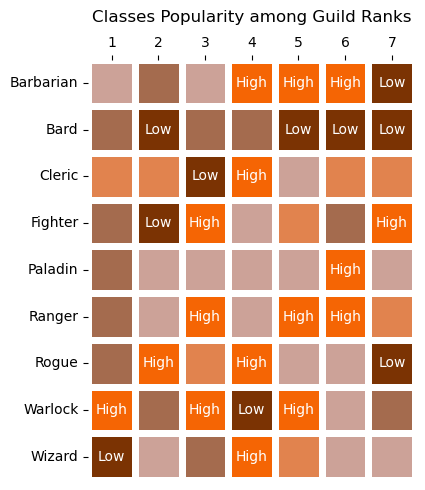

In [82]:
fig,ax = plt.subplots(figsize=(5,5))

sns.heatmap(
    NPS,
    annot=labels_score,
    square=True,
    fmt='',
    cmap=nw_cmap_heatmap_5,
    vmin=low_popularity-0.075,
    vmax=high_popularity+0.1,
    cbar=False,
    linewidths=5,
    ax=ax
)
ax.xaxis.tick_top()
ax.set(xlabel="", ylabel="")
ax.set_title('Classes Popularity among Guild Ranks',pad=10)

plt.tight_layout()

In [83]:
_M_char_qty = _popular_classes.pivot(index='character_class',columns='guild_rank', values='characters').fillna(0).astype(int)
_M_char_qty

guild_rank       1  2  3   4   5  6  7
character_class                       
Barbarian        5  4  7  11  10  4  0
Bard             1  0  2   3   1  3  0
Cleric           6  7  8  13   9  5  3
Fighter          5  2  4   7  11  4  2
Paladin          2  3  5   9  11  6  1
Ranger           3  3  7   8   6  4  1
Rogue            3  1  6  13  15  4  2
Warlock          2  4  4  12  11  3  2
Wizard           3  4  5  11  14  4  5

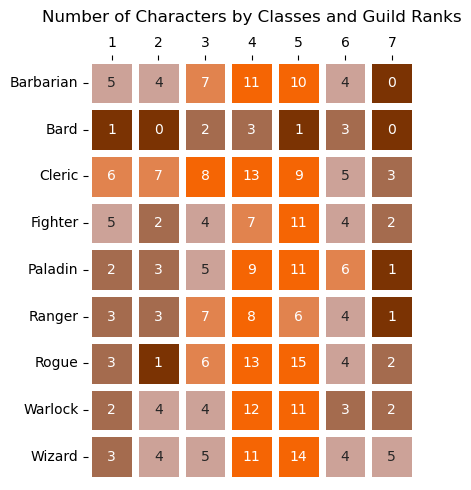

In [84]:
fig,ax = plt.subplots(figsize=(5,5))

sns.heatmap(
    _M_char_qty,
    annot=_M_char_qty,
    square=True,
    cmap=nw_cmap_heatmap_5,
    vmin=0,
    vmax=10,
    cbar=False,
    linewidths=5,
    ax=ax
)
ax.xaxis.tick_top()
ax.set(xlabel="", ylabel="")
ax.set_title('Number of Characters by Classes and Guild Ranks',pad=10)

plt.tight_layout()

## Guild Ranks

In [86]:
df_guild.head(1)

character         account character_class  guild_rank  contribution  \
0    oSwowo  @@2@2#73ncr3o@           Rogue           6        485165   

     last_active_date  days_inactive  
0 2021-12-28 09:50:03              0

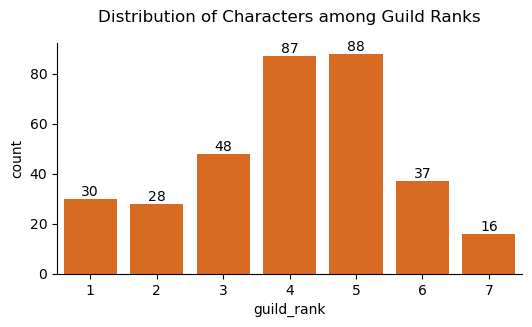

In [87]:
plt.figure(figsize=(6, 3))
s = sns.countplot(
    x='guild_rank',
    data=df_guild,
    order=sorted(df_guild['guild_rank'].unique()),
    color=nw_clr_single
)
s.bar_label(s.containers[0])
plt.title('Distribution of Characters among Guild Ranks', pad=15)
sns.despine()

In [88]:
_accounts = df_guild.groupby('guild_rank')['account'].nunique().reset_index()
_accounts

guild_rank  account
0           1       27
1           2       20
2           3       27
3           4       31
4           5       29
5           6        8
6           7        3

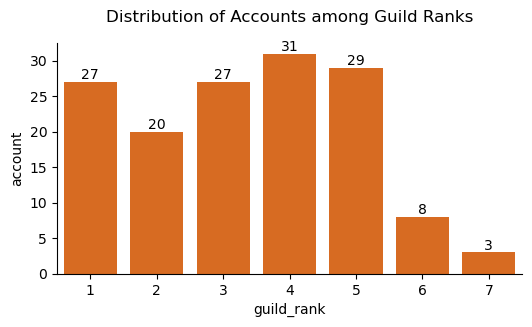

In [89]:
plt.figure(figsize=(6, 3))
s = sns.barplot(x='guild_rank', y='account', data=_accounts, color=nw_clr_single)
s.bar_label(s.containers[0])
plt.title('Distribution of Accounts among Guild Ranks', pad=15);
sns.despine()

In [90]:
_accounts = df_guild.groupby('account')['guild_rank'].max().reset_index().groupby('guild_rank')['account'].count().reset_index()
_accounts

guild_rank  account
0           1       22
1           2       19
2           3       27
3           4       28
4           5       29
5           6        8
6           7        3

In [91]:
# Total accounts (~players) in guild
_accounts['account'].sum()

136

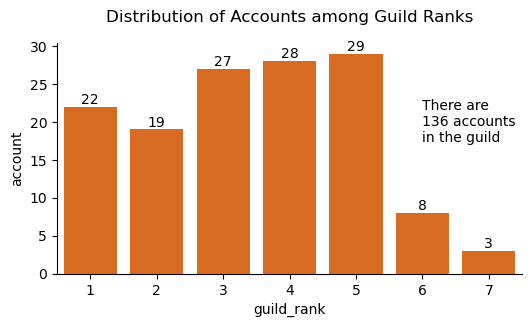

In [92]:
plt.figure(figsize=(6, 3))
s = sns.barplot(x='guild_rank', y='account', data=_accounts, color=nw_clr_single)
s.bar_label(s.containers[0])
plt.text(x=5,y=20,va='center', ha='left', s=f"There are\n{_accounts['account'].sum()} accounts\nin the guild")
plt.title('Distribution of Accounts among Guild Ranks', pad=15);
sns.despine()

# TimeSeries Analysis (basic)

## Guild Activity

In [93]:
_activity_time = df_guild.groupby(['character','guild_rank','character_class'])['days_inactive'].sum().reset_index()
_activity_time.head(1)

character  guild_rank character_class  days_inactive
0    zae  r Yz ee           4           Rogue              0

In [94]:
activity_matrix = _activity_time.pivot_table(index='character_class', columns='days_inactive', values='character', aggfunc='count').iloc[:,1:]
activity_matrix

days_inactive       1       2       3       4       5       6       8    \
character_class                                                           
Barbarian       4.00000 6.00000     NaN 1.00000 1.00000 2.00000     NaN   
Bard            3.00000 2.00000     NaN     NaN     NaN     NaN     NaN   
Cleric          6.00000 3.00000     NaN 3.00000 1.00000 1.00000 1.00000   
Fighter         4.00000 1.00000 1.00000     NaN 1.00000     NaN     NaN   
Paladin         6.00000 1.00000 2.00000 2.00000 1.00000     NaN     NaN   
Ranger          3.00000 3.00000 1.00000 2.00000 1.00000     NaN     NaN   
Rogue           5.00000 4.00000     NaN 1.00000 2.00000     NaN     NaN   
Warlock         2.00000 4.00000     NaN 1.00000 1.00000     NaN     NaN   
Wizard          5.00000 3.00000     NaN 2.00000     NaN     NaN     NaN   

days_inactive       9       11      12      14      16      17      19   \
character_class                                                           
Barbarian           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Bard                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cleric          1.00000 1.00000     NaN     NaN     NaN     NaN     NaN   
Fighter         2.00000     NaN     NaN 1.00000     NaN     NaN     NaN   
Paladin         1.00000     NaN     NaN     NaN 1.00000     NaN 1.00000   
Ranger              NaN 1.00000     NaN     NaN     NaN 2.00000     NaN   
Rogue           1.00000     NaN 1.00000     NaN     NaN     NaN     NaN   
Warlock             NaN     NaN     NaN     NaN 1.00000     NaN     NaN   
Wizard          1.00000 1.00000     NaN     NaN     NaN     NaN     NaN   

days_inactive       20      22      25      26      30      31      33   \
character_class                                                           
Barbarian           NaN     NaN     NaN     NaN 1.00000     NaN 1.00000   
Bard                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cleric          1.00000     NaN     NaN 1.00000     NaN     NaN     NaN   
Fighter             NaN     NaN     NaN 1.00000 1.00000     NaN     NaN   
Paladin             NaN     NaN 1.00000     NaN     NaN     NaN     NaN   
Ranger              NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Rogue               NaN     NaN     NaN 2.00000     NaN     NaN     NaN   
Warlock             NaN     NaN 1.00000     NaN     NaN 1.00000     NaN   
Wizard              NaN 1.00000     NaN 1.00000     NaN     NaN     NaN   

days_inactive       34      39      41      45      46      52      53   \
character_class                                                           
Barbarian           NaN     NaN     NaN 1.00000     NaN     NaN     NaN   
Bard                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cleric              NaN     NaN     NaN     NaN     NaN     NaN 1.00000   
Fighter             NaN 1.00000     NaN     NaN     NaN     NaN     NaN   
Paladin             NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Ranger              NaN     NaN 1.00000     NaN     NaN     NaN     NaN   
Rogue               NaN     NaN     NaN     NaN     NaN 1.00000 1.00000   
Warlock             NaN     NaN     NaN     NaN 1.00000     NaN     NaN   
Wizard          1.00000     NaN     NaN     NaN     NaN 1.00000     NaN   

days_inactive       58      63      66      70      73      74      75   \
character_class                                                           
Barbarian           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Bard                NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Cleric              NaN 1.00000     NaN     NaN     NaN     NaN     NaN   
Fighter             NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Paladin             NaN     NaN     NaN     NaN     NaN     NaN 1.00000   
Ranger              NaN     NaN     NaN     NaN     NaN 1.00000     NaN   
Rogue           1.00000     NaN     NaN     NaN 2.00000     NaN 1.00000   
Warlock             N

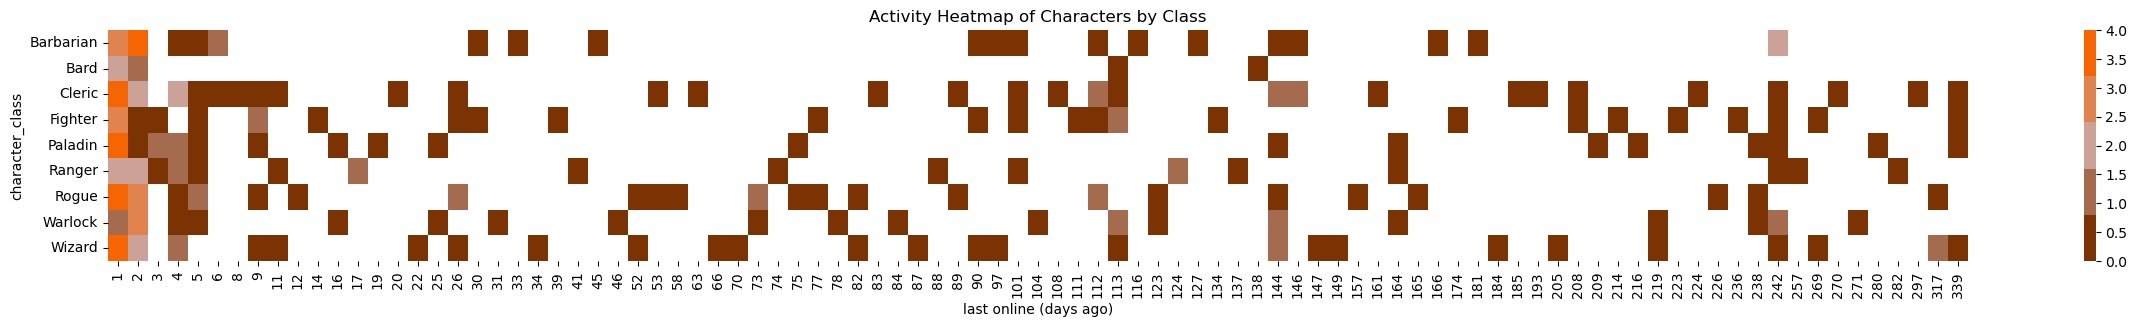

In [95]:
plt.figure(figsize=(30, 3))
sns.heatmap(activity_matrix-1, cmap=nw_cmap_heatmap_5, vmax=4)
plt.xlabel('last online (days ago)')
plt.title('Activity Heatmap of Characters by Class')
plt.yticks(rotation=0)
plt.show()

In [96]:
activity_matrix = _activity_time.pivot_table(index='guild_rank', columns='days_inactive', values='character', aggfunc='count').iloc[:,1:].replace(0,np.nan)
activity_matrix

days_inactive     1        2       3        4       5       6       8    \
guild_rank                                                                
1             6.00000  1.00000     NaN      NaN 1.00000     NaN     NaN   
2             2.00000      NaN     NaN      NaN     NaN     NaN     NaN   
3             4.00000  5.00000     NaN      NaN     NaN 1.00000     NaN   
4             9.00000 13.00000 1.00000  1.00000 5.00000 1.00000 1.00000   
5             8.00000  7.00000 1.00000 11.00000 2.00000 1.00000     NaN   
6             3.00000  1.00000 2.00000      NaN     NaN     NaN     NaN   
7             6.00000      NaN     NaN      NaN     NaN     NaN     NaN   

days_inactive     9       11      12      14      16      17      19      20   \
guild_rank                                                                      
1                 NaN 1.00000     NaN     NaN     NaN     NaN     NaN     NaN   
2             1.00000     NaN     NaN     NaN     NaN 1.00000     NaN 1.00000   
3             3.00000     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4             1.00000 1.00000     NaN     NaN     NaN     NaN     NaN     NaN   
5                 NaN 1.00000 1.00000 1.00000 2.00000 1.00000     NaN     NaN   
6             1.00000     NaN     NaN     NaN     NaN     NaN 1.00000     NaN   
7                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

days_inactive     22      25      26      30      31      33      34      39   \
guild_rank                                                                      
1             1.00000     NaN 1.00000     NaN     NaN 1.00000     NaN     NaN   
2                 NaN 2.00000 3.00000     NaN     NaN     NaN     NaN     NaN   
3                 NaN     NaN     NaN 1.00000     NaN     NaN     NaN     NaN   
4                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5                 NaN     NaN     NaN     NaN 1.00000     NaN 1.00000     NaN   
6                 NaN     NaN 1.00000 1.00000     NaN     NaN     NaN 1.00000   
7                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

days_inactive     41      45      46      52      53      58      63      66   \
guild_rank                                                                      
1                 NaN     NaN     NaN     NaN     NaN     NaN 1.00000     NaN   
2                 NaN     NaN 1.00000     NaN     NaN     NaN     NaN     NaN   
3                 NaN 1.00000     NaN     NaN 2.00000     NaN     NaN 1.00000   
4             1.00000     NaN     NaN 1.00000     NaN 1.00000     NaN     NaN   
5                 NaN     NaN     NaN 1.00000     NaN     NaN     NaN     NaN   
6                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

days_inactive     70      73      74      75      77      78      82      83   \
guild_rank                                                                      
1                 NaN     NaN     NaN 1.00000 1.00000     NaN     NaN 1.00000   
2             1.00000     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3                 NaN     NaN 1.00000     NaN     NaN     NaN     NaN     NaN   
4                 NaN 2.00000     NaN     NaN 1.00000     NaN     NaN     NaN   
5                 NaN 1.00000     NaN 1.00000     NaN 1.00000 2.00000     NaN   
6                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

days_inactive     84      87      88      89      90      97      101     104  \
guild_rank                                                                      
1                 NaN     NaN     NaN     NaN 1.00000 1.00000     NaN     NaN   
2                 NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3             1.00000     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

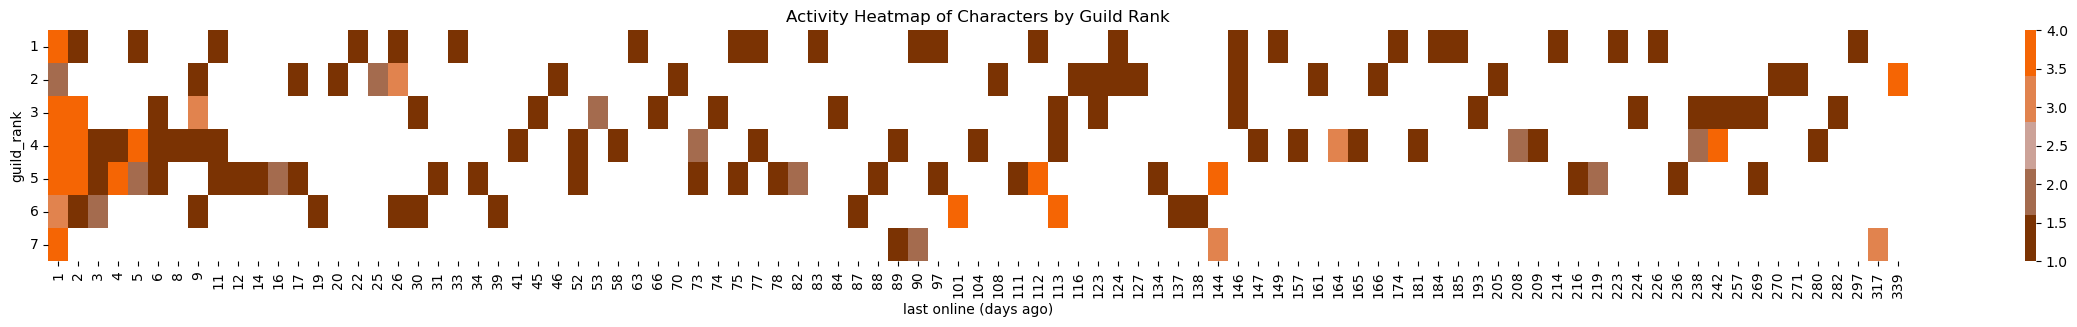

In [97]:
plt.figure(figsize=(30, 3))
sns.heatmap(activity_matrix, cmap=nw_cmap_heatmap_5,vmax=4)
plt.xlabel('last online (days ago)')
plt.title('Activity Heatmap of Characters by Guild Rank')
plt.yticks(rotation=0)
plt.show()

## Characters dropout

In [98]:
df_guild.head(1)

character         account character_class  guild_rank  contribution  \
0    oSwowo  @@2@2#73ncr3o@           Rogue           6        485165   

     last_active_date  days_inactive  
0 2021-12-28 09:50:03              0

<Axes: >

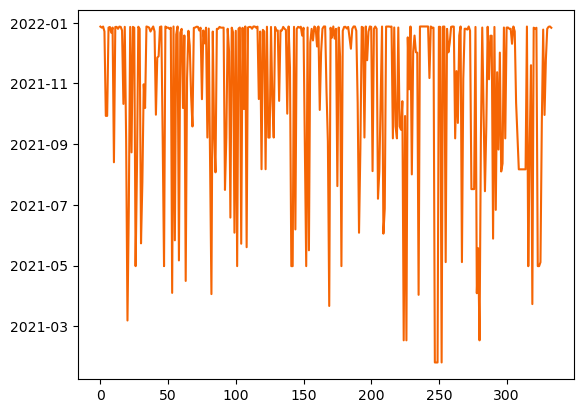

In [99]:
plt.plot()
df_guild['last_active_date'].plot(color=nw_clr_single)

In [100]:
_ts_last_active = df_guild.groupby('last_active_date')['character'].count()
_ts_last_active = _ts_last_active.reset_index().set_index('last_active_date').rename(columns={'character':'characters'})
_ts_last_active.head()

characters
last_active_date               
2021-01-23 01:48:03           1
2021-01-23 01:50:35           1
2021-01-23 01:52:44           1
2021-01-23 02:05:00           1
2021-02-14 10:31:59           1

<Axes: xlabel='last_active_date'>

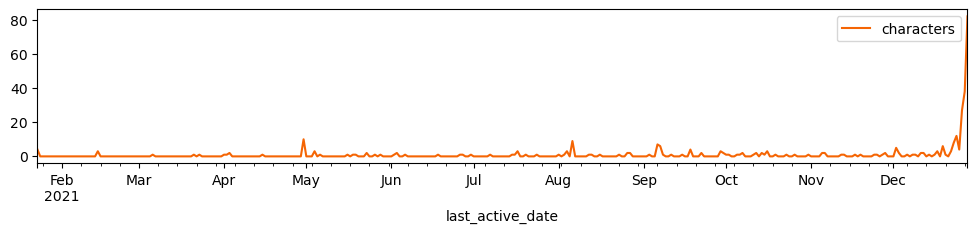

In [101]:
_ts_last_active.resample('D').sum().plot(figsize=(12,2), color=nw_clr_single)

<Axes: xlabel='last_active_date'>

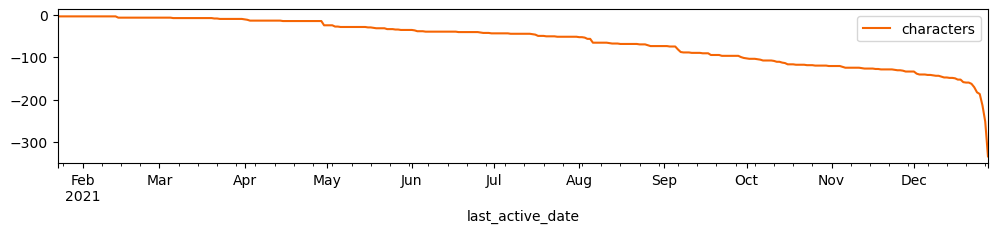

In [102]:
(_ts_last_active.resample('D').sum()*-1).cumsum().plot(figsize=(12,2), color=nw_clr_single)

In [103]:
import datetime as dt
import matplotlib.dates as mdates

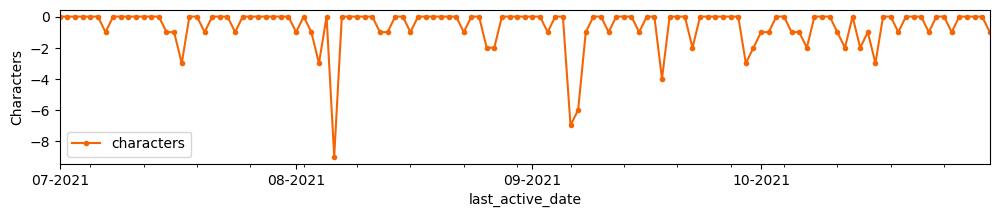

In [104]:
ax = (_ts_last_active.resample('D').sum()*-1).loc['2021-07':'2021-10'].plot(figsize=(12,2), marker='o', linestyle='-', markersize=3, color=nw_clr_single)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

ax.set_ylabel('Characters');

<Axes: xlabel='last_active_date'>

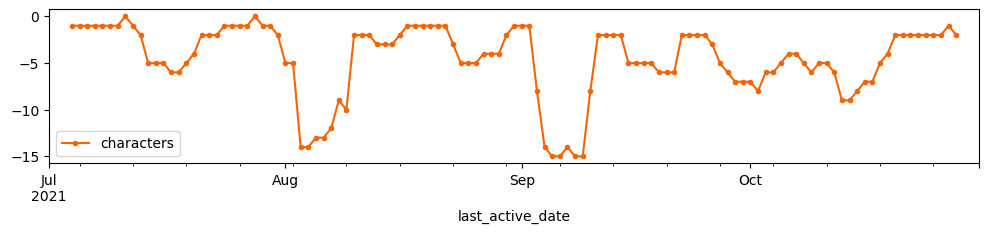

In [105]:
(_ts_last_active.resample('D').sum()*-1).loc['2021-07':'2021-10'].rolling(7, center=True).sum().plot(figsize=(12,2), marker='o', linestyle='-', markersize=3, color=nw_clr_single)

<Axes: xlabel='last_active_date'>

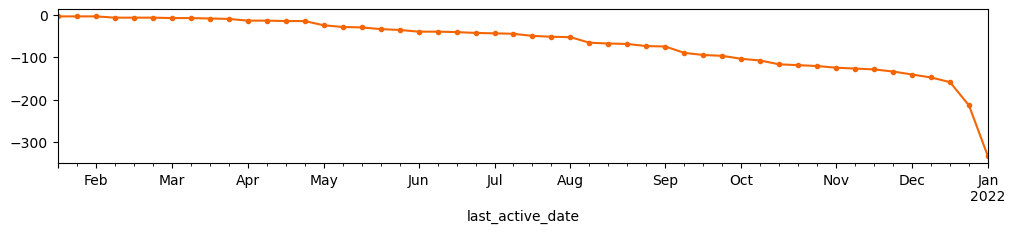

In [106]:
(_ts_last_active.groupby(pd.Grouper(freq='W'))['characters'].sum()*-1).cumsum().plot(figsize=(12,2), marker='o', linestyle='-', markersize=3, color=nw_clr_single)

In [107]:
df_guild['character'].count()

334

In [108]:
[pd.to_datetime('2021-01-23 00:00:01'),df_guild['character'].count()]

[Timestamp('2021-01-23 00:00:01'), 334]

In [109]:
_ts_chars_active = _ts_last_active.copy()*-1
_ts_chars_active.loc[pd.to_datetime('2021-01-23 00:00:01')] = df_guild['character'].count()
_ts_chars_active = _ts_chars_active.sort_index().cumsum()
_ts_chars_active.head()

characters
last_active_date               
2021-01-23 00:00:01         334
2021-01-23 01:48:03         333
2021-01-23 01:50:35         332
2021-01-23 01:52:44         331
2021-01-23 02:05:00         330

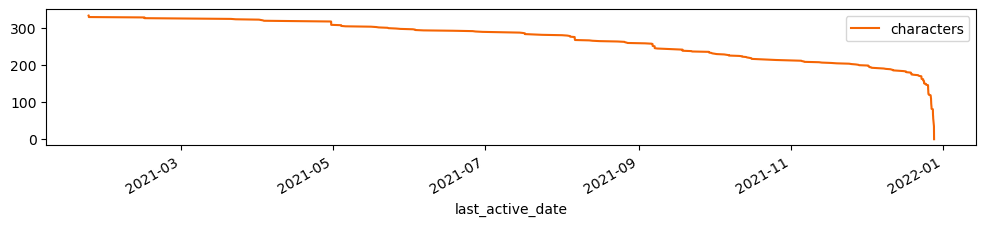

In [110]:
_ts_chars_active.plot(figsize=(12,2), color=nw_clr_single);

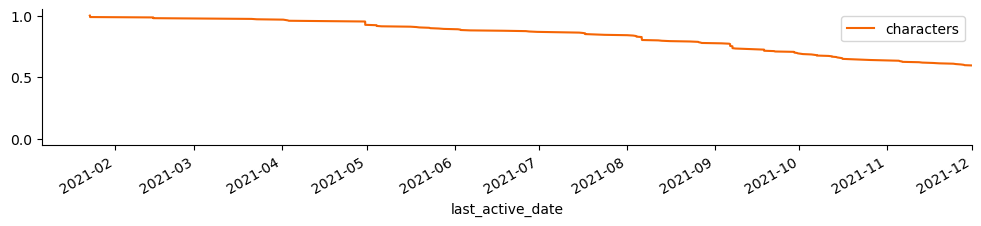

In [111]:
(_ts_chars_active / df_guild['character'].count()).plot(figsize=(12,2), color=nw_clr_single)
plt.xlim(right=dt.datetime(2021, 12, 1))
sns.despine()

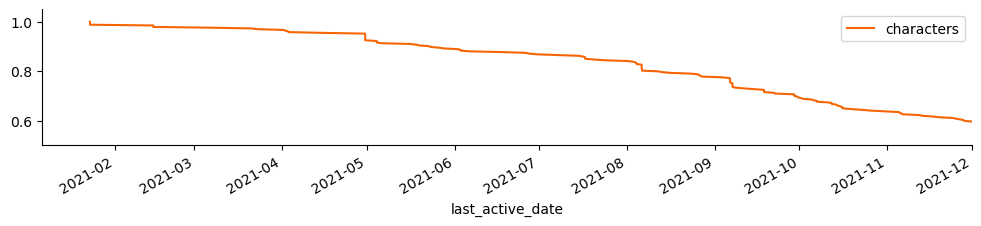

In [112]:
(_ts_chars_active / df_guild['character'].count()).plot(figsize=(12,2), color=nw_clr_single)
plt.xlim(right=dt.datetime(2021, 12, 1))
plt.ylim(bottom=0.5)
sns.despine()

In [113]:
_ts_chars_active['pct_chars'] = _ts_chars_active / df_guild['character'].count()
_ts_chars_active.head()

characters  pct_chars
last_active_date                          
2021-01-23 00:00:01         334    1.00000
2021-01-23 01:48:03         333    0.99701
2021-01-23 01:50:35         332    0.99401
2021-01-23 01:52:44         331    0.99102
2021-01-23 02:05:00         330    0.98802

In [114]:
_ts_chars_active['abs_dif'] = abs(_ts_chars_active['characters'].diff())
_ts_chars_active

characters  pct_chars  abs_dif
last_active_date                                   
2021-01-23 00:00:01         334    1.00000      NaN
2021-01-23 01:48:03         333    0.99701  1.00000
2021-01-23 01:50:35         332    0.99401  1.00000
2021-01-23 01:52:44         331    0.99102  1.00000
2021-01-23 02:05:00         330    0.98802  1.00000
...                         ...        ...      ...
2021-12-28 12:46:16           4    0.01198  1.00000
2021-12-28 12:46:30           3    0.00898  1.00000
2021-12-28 12:46:31           2    0.00599  1.00000
2021-12-28 12:48:39           1    0.00299  1.00000
2021-12-28 12:50:01           0    0.00000  1.00000

[335 rows x 3 columns]

(2665.0, 2710.0)

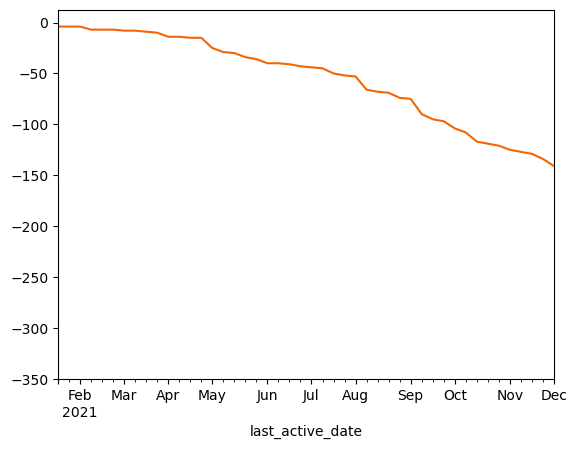

In [115]:
(_ts_chars_active.groupby(pd.Grouper(freq='W'))['abs_dif'].sum()*-1).cumsum().plot(color=nw_clr_single)
plt.xlim(right=dt.datetime(2021, 12, 1))

In [116]:
monthly_characters_diff = _ts_chars_active.groupby(pd.Grouper(freq='M'))['abs_dif'].sum().sort_values(ascending=False)
monthly_characters_diff

last_active_date
2021-12-31   200.00000
2021-09-30    28.00000
2021-08-31    22.00000
2021-10-31    19.00000
2021-04-30    15.00000
2021-11-30    13.00000
2021-05-31    11.00000
2021-06-30     8.00000
2021-07-31     8.00000
2021-01-31     4.00000
2021-02-28     3.00000
2021-03-31     3.00000
Name: abs_dif, dtype: float64

In [117]:
type(monthly_characters_diff)

pandas.core.series.Series

In [118]:
monthly_characters_diff = monthly_characters_diff.iloc[1:].sort_index()
monthly_characters_diff

last_active_date
2021-01-31    4.00000
2021-02-28    3.00000
2021-03-31    3.00000
2021-04-30   15.00000
2021-05-31   11.00000
2021-06-30    8.00000
2021-07-31    8.00000
2021-08-31   22.00000
2021-09-30   28.00000
2021-10-31   19.00000
2021-11-30   13.00000
Name: abs_dif, dtype: float64

In [119]:
monthly_characters_diff.index.month_name()

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November'],
      dtype='object', name='last_active_date')

In [120]:
full_date_range = pd.date_range(start=monthly_characters_diff.index.min(), end=monthly_characters_diff.index.max(), freq='M')
full_date_range

DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', freq='ME')

In [121]:
# Reindex the DataFrame to include the full date range, filling missing values with 0
monthly_characters_diff = monthly_characters_diff.reindex(full_date_range, fill_value=0)
monthly_characters_diff

2021-01-31    4.00000
2021-02-28    3.00000
2021-03-31    3.00000
2021-04-30   15.00000
2021-05-31   11.00000
2021-06-30    8.00000
2021-07-31    8.00000
2021-08-31   22.00000
2021-09-30   28.00000
2021-10-31   19.00000
2021-11-30   13.00000
Freq: ME, Name: abs_dif, dtype: float64

In [122]:
_colors = {}
for i,c in enumerate(monthly_characters_diff.index.month_name()):
    if monthly_characters_diff[i]==monthly_characters_diff.max():
        _colors[c]=nw_clr_single
    else:
        _colors[c]=nw_clr_single_greyed

_colors

{'January': '#cca299',
 'February': '#cca299',
 'March': '#cca299',
 'April': '#cca299',
 'May': '#cca299',
 'June': '#cca299',
 'July': '#cca299',
 'August': '#cca299',
 'September': '#f56504',
 'October': '#cca299',
 'November': '#cca299'}

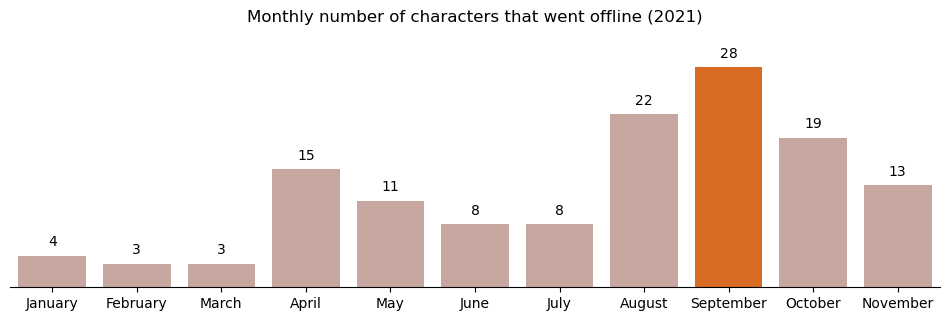

In [123]:
fig, ax = plt.subplots(figsize=(12, 3))
s = sns.barplot(
    ax=ax,
    x=monthly_characters_diff.index.month_name(),
    y=monthly_characters_diff,
    legend=False,
    hue=monthly_characters_diff.index.month_name(),
    palette=_colors
)

for container in s.containers:
    tmp_hue = monthly_characters_diff[monthly_characters_diff.index.month_name()==container.get_label()]
    ax.bar_label(container, labels=tmp_hue, padding=5, fmt='{:,.0f}')

ax.set(ylabel=None, yticks=[])


plt.title('Monthly number of characters that went offline (2021)', pad=25)
plt.xlabel('')
sns.despine(left=True)

# Statistical Analysis

- Data overall seems to be mostly discrete by nature and doesn't assume continuity.
- Contribution variable doesn't seem to follow a normal distribution, has a substantial amount of zero values, and large variance.
- The dataset represents population of the guild.
- The Bard class has a small sample size, therefore it should not be used to make any strong conclusions.

## Correlation

Quick correlation overview to see whether any variables have a directional relationship.

Non-Parametric, Spearman's correlation is chosen here because it doesn't assume distribution or linear relationship, and feels ok around extreme values.

In [124]:
df_guild.corr(method='spearman', numeric_only=True).style.background_gradient('YlOrRd', vmin=-0.5, vmax=0.5).format(precision=2)

Some interesting relationship seems to exist between **Guild Rank** and **Contribution**, and a less pronounced one between **Guild Rank** and **Days of Inactivity**.

In [125]:
df_guild[~df_guild['account'].isin(_contrib_outliers_acc)].corr(method='spearman', numeric_only=True).style.background_gradient('YlOrRd', vmin=-0.5, vmax=0.5).format(precision=2)

After removing some contribution outliers, the correlation between **Guild Rank** and **Days of Inactivity** became visibly stronger.

In [126]:
import pingouin as pg

### Guild Rank and Contribution

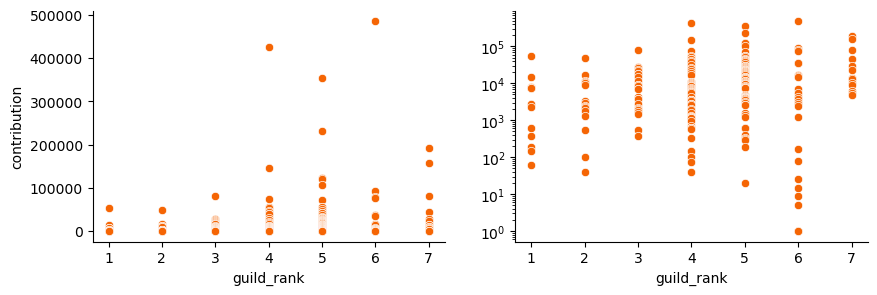

In [127]:
fig, (ax1,ax2) =  plt.subplots(1,2, figsize=(10,3), sharex=True)

sns.scatterplot(ax=ax1, y=df_guild['contribution'],x=df_guild['guild_rank'], color=nw_clr_single)
sns.scatterplot(ax=ax2, y=df_guild['contribution'],x=df_guild['guild_rank'], color=nw_clr_single).set_yscale('log')

ax2.set_ylabel('')
sns.despine()

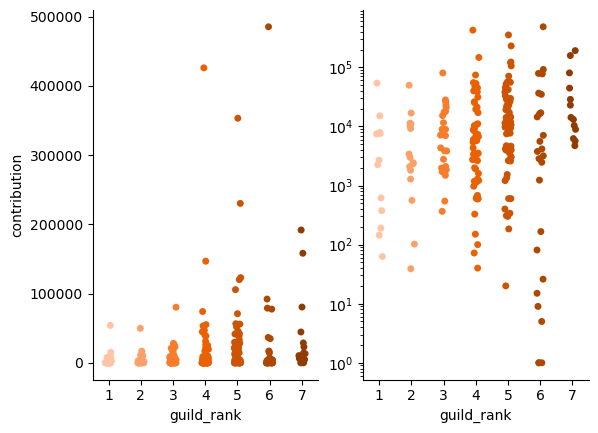

In [128]:
fig, (ax1,ax2) =  plt.subplots(1,2, sharex=True)

sns.stripplot(ax=ax1, x='guild_rank', y='contribution', data=df_guild, hue='guild_rank', legend=False, jitter=True, palette=nw_palette)

sns.stripplot(ax=ax2, x='guild_rank', y='contribution', data=df_guild, hue='guild_rank', legend=False, jitter=True, palette=nw_palette)
ax2.set_yscale('log')
ax2.set_ylabel('')

sns.despine()

    Hypothesis Statement:

    H0: r = 0, There is no correlation between Guild Rank and Contributions
    H1: r != 0, There is correlation between Guild Rank and Contributions
    
    alpha = 0.05

In [129]:
spearman = pg.corr(df_guild['guild_rank'], df_guild['contribution'], method='spearman')
print("Spearman correlation between Guild Rank and Contribution Total:\n\n", spearman)

Spearman correlation between Guild Rank and Contribution Total:

             n       r         CI95%   p-val   power
spearman  334 0.28019  [0.18, 0.38] 0.00000 0.99949


In [130]:
# Compute bootstrapped CI for a  more comprehensive view 
pg.compute_bootci(x=df_guild['guild_rank'], y=df_guild['contribution'], func='spearman', paired=True, n_boot=1000)

array([0.18, 0.37])

In [131]:
# Check if data with no outliers has any different results (should not given the test nature)
spearman = pg.corr(
    df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['guild_rank'],
    df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution'],
    method='spearman'
)
print("Spearman correlation between Guild Rank and Contribution Total (outliers excl.):\n\n", spearman)

Spearman correlation between Guild Rank and Contribution Total (outliers excl.):

             n       r         CI95%   p-val   power
spearman  295 0.28066  [0.17, 0.38] 0.00000 0.99854


Nothing really changed.

#### Correlation Test Summary
- **p-value** shows the relationship is **statistically significant**;
- **Confidence Interval (CI)**, including the bootstrapped, doesn't include 0, and is positive, meaning that **guild rank and contribution have a positive correlation** at 95%CI;
- **r (rho)** of ~0.3 shows that the relationship is moderate.

The assumption might be that as guild rank increases so does the amount of contributions. This is a logical conclusion since contribution data represents accumulated contribution, and high-rank guild members have a higher contribution simply due to the fact that they are longer with the guild. However, analyzing this relationship, without any temporal data that would show progress of each character, might lead to a circular reasoning.

Nevertheless, I might use the fact that there are so many zero contributions, to see probabilities of having/not having zero contribution at each guild rank. The logistic regression should work just fine here. 

### Guild Rank and Days Inactive 

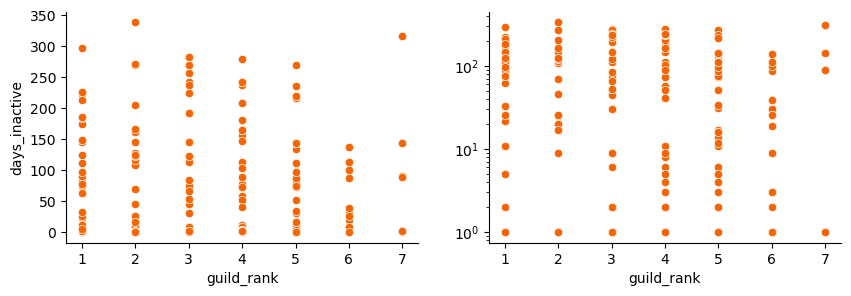

In [132]:
fig, (ax1,ax2) =  plt.subplots(1,2, figsize=(10,3), sharex=True)

sns.scatterplot(ax=ax1, y=df_guild['days_inactive'],x=df_guild['guild_rank'], color=nw_clr_single)
sns.scatterplot(ax=ax2, y=df_guild['days_inactive'],x=df_guild['guild_rank'], color=nw_clr_single).set_yscale('log')

ax2.set_ylabel('')
sns.despine()

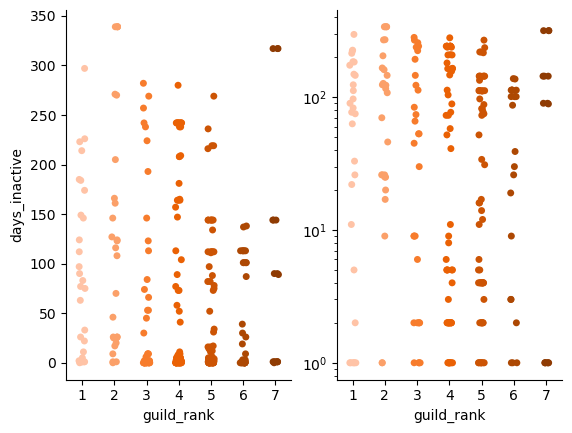

In [133]:
fig, (ax1,ax2) =  plt.subplots(1,2, sharex=True)
sns.stripplot(ax=ax1, x='guild_rank', y='days_inactive', data=df_guild, hue='guild_rank', legend=False, jitter=True, palette=nw_palette)

sns.stripplot(ax=ax2, x='guild_rank', y='days_inactive', data=df_guild, hue='guild_rank', legend=False, jitter=True, palette=nw_palette)

ax2.set_yscale('log')
ax2.set_ylabel('')
sns.despine()

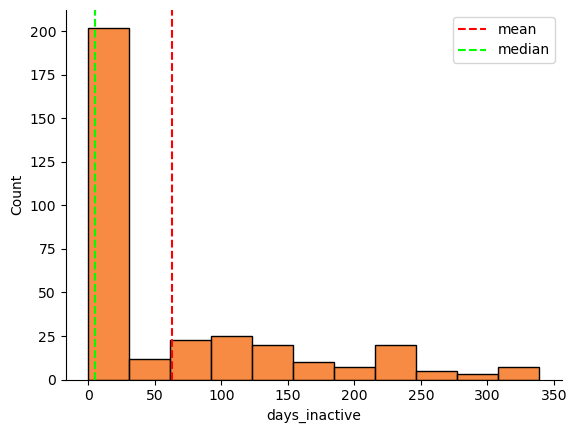

In [134]:
sns.histplot(df_guild['days_inactive'], color=nw_clr_single)
_mean_line = plt.axvline(df_guild['days_inactive'].mean(), color='red', ls='--').set_label('mean')
_median_line = plt.axvline(df_guild['days_inactive'].median(), color='lime', ls='--').set_label('median')
plt.legend()
sns.despine()

    Hypothesis Statement:

    H0: r = 0, There is no correlation between Guild Rank and Days Inactive
    H1: r != 0, There is correlation between Guild Rank and Days Inactive
    
    alpha = 0.05

In [135]:
spearman = pg.corr(df_guild['guild_rank'], df_guild['days_inactive'], method='spearman')
print("Spearman correlation between Guild Rank and Days of Inactivity:\n\n", spearman)

Spearman correlation between Guild Rank and Days of Inactivity:

             n        r           CI95%   p-val   power
spearman  334 -0.15629  [-0.26, -0.05] 0.00419 0.81882


In [136]:
# Compute bootstrapped CI for a  more comprehensive view 
pg.compute_bootci(x=df_guild['guild_rank'], y=df_guild['days_inactive'], func='spearman', paired=True, n_boot=1000)

array([-0.27, -0.06])

In [137]:
spearman = pg.corr(df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['guild_rank'], df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['days_inactive'], method='spearman')
print("Spearman correlation between Guild Rank and Days of Inactivity (outliers excl.):\n\n", spearman)

Spearman correlation between Guild Rank and Days of Inactivity (outliers excl.):

             n        r           CI95%   p-val   power
spearman  295 -0.23730  [-0.34, -0.13] 0.00004 0.98538


Excluding outliers has proven to produce better results, even when taking into account that Spearman ranks correlation was used.

#### Correlation Test Summary
- **p-value** shows the relationship is **statistically significant** fot both tests, with and without outliers;
- **Confidence Interval (CI)**, including the one with outliers, doesn't include 0, and is marginally negative, meaning that **guild rank and days inactive have a negative correlation**;
- **r (rho)** of ~0.24 shows that the strength of the relationship is approximately moderate.

The results suggest that as guild rank increases, the number of inactive days decreases. In other words, higher rank members seem to be online more frequently.

This does overall align with reality, even when taking into account that the relationship strength is quite low.<br>It is not abnormal, since guild officers and leaders tend to have more responsibilities, like recruiting new players or tending guild structures, that reach max resources cap every day.

Nevertheless, further analysis of the relationship will not provide any practical importance, and therefore will not be conducted.

### Contribution and Class

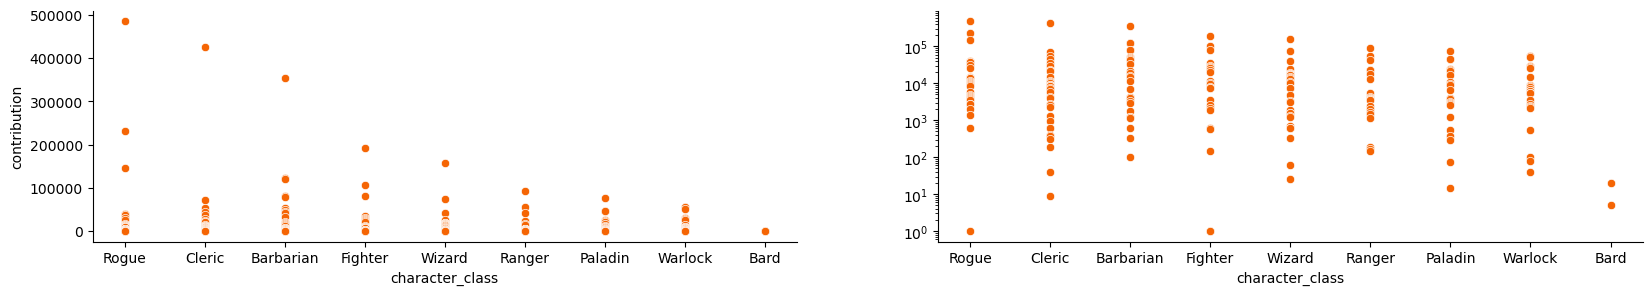

In [138]:
fig, (ax1,ax2) =  plt.subplots(1,2, figsize=(20,3), sharex=True)

sns.scatterplot(ax=ax1, y=df_guild['contribution'],x=df_guild['character_class'], color=nw_clr_single)
sns.scatterplot(ax=ax2, y=df_guild['contribution'],x=df_guild['character_class'], color=nw_clr_single).set_yscale('log')

ax2.set_ylabel('')
sns.despine()

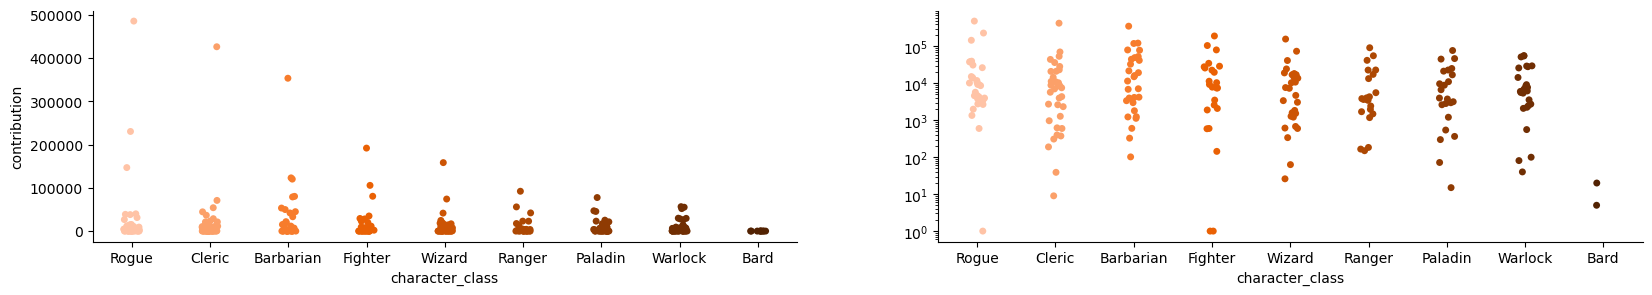

In [139]:
fig, (ax1,ax2) =  plt.subplots(1,2, figsize=(20,3), sharex=True)
sns.stripplot(ax=ax1, x='character_class', y='contribution', data=df_guild, hue='character_class', legend=False, jitter=True, palette=nw_palette)

sns.stripplot(ax=ax2, x='character_class', y='contribution', data=df_guild, hue='character_class', legend=False, jitter=True, palette=nw_palette)

ax2.set_yscale('log')
ax2.set_ylabel('')
sns.despine()

- Character class is categorical nominal variable and contribution is discrete numerical. However, the Spearman correlation needs at least one variable to be ordinal.
- Another thing is that contribution contains a lost of zero values.
- The sample size for Bard is too small to make any conclusions.

Therefore I might try to create another variable (binary) representing whether contribution is zero or not. Then I will use the Chi-square test, to test wether there is any significant relationship between a character class and likelyhood of making non-zero contributions.

In [140]:
df_guild['non_zero_contribution'] = (df_guild['contribution'] > 0).astype(int)
df_guild.head(1)

character         account character_class  guild_rank  contribution  \
0    oSwowo  @@2@2#73ncr3o@           Rogue           6        485165   

     last_active_date  days_inactive  non_zero_contribution  
0 2021-12-28 09:50:03              0                      1

In [141]:
df_guild['non_zero_contribution'].value_counts()

non_zero_contribution
1    221
0    113
Name: count, dtype: int64

In [142]:
from scipy.stats import chi2_contingency
cross_tab=pd.crosstab(index=df_guild['character_class'],columns=df_guild['non_zero_contribution'])
print(cross_tab)

non_zero_contribution   0   1
character_class              
Barbarian              12  29
Bard                    8   2
Cleric                 16  35
Fighter                11  24
Paladin                14  23
Ranger                 10  22
Rogue                  14  30
Warlock                13  25
Wizard                 15  31


In [143]:
chi_sq_result = chi2_contingency(cross_tab,)
chi_sq_result

Chi2ContingencyResult(statistic=10.604464404534607, pvalue=0.22513322888099338, dof=8, expected_freq=array([[13.87125749, 27.12874251],
       [ 3.38323353,  6.61676647],
       [17.25449102, 33.74550898],
       [11.84131737, 23.15868263],
       [12.51796407, 24.48203593],
       [10.82634731, 21.17365269],
       [14.88622754, 29.11377246],
       [12.85628743, 25.14371257],
       [15.56287425, 30.43712575]]))

In [144]:
p = chi_sq_result[1]
p_conclusion = "Reject" if chi_sq_result[1] < 0.05 else "Fail to reject"
 
print(f"The p-value is {chi_sq_result[1]:.5f} and hence we {p_conclusion} the Null Hpothesis with {chi_sq_result[2]} degrees of freedom.")

The p-value is 0.22513 and hence we Fail to reject the Null Hpothesis with 8 degrees of freedom.


#### Relationship Test Summary
- There is no strong evidence of a significant relationship between character class and the likelihood of making non-zero contributions.
- The choice of character class doesn't seem to strongly influence whether a player makes contributions or not.
- The contribution behavior appears to be relatively consistent across most character classes.
- **The Bard class has a small sample size, therefore it is not viable in terms of making any conclusions.**

## Difference among groups
**Kruskal-Wallis H-test** is chosen here due to existance of more than 2 groups, as well as outliers. 

alpha = 0.05

### Contribution among Guild Ranks

In [145]:
h_statistic = pg.kruskal(data=df_guild, dv='contribution', between='guild_rank')
print('Test for difference in contribution among guild ranks')
print(f"H-statistic: {h_statistic['H'][0]:.5f}, p-value: {h_statistic['p-unc'][0]:.5f}")

p_result = 'Reject Null Hypothesis: There is difference in contribution among guild ranks' if h_statistic['p-unc'][0] < 0.05 else 'Fail to reject Null Hypothesis: There is no difference in contribution among guild ranks.'
print(p_result)

Test for difference in contribution among guild ranks
H-statistic: 39.24688, p-value: 0.00000
Reject Null Hypothesis: There is difference in contribution among guild ranks


### Contribution among Character Classes

In [146]:
h_statistic = pg.kruskal(data=df_guild, dv='contribution', between='character_class')
print('Test for difference in contribution among character classes')
print(f"H-statistic: {h_statistic['H'][0]:.5f}, p-value: {h_statistic['p-unc'][0]:.5f}")

p_result = 'Reject Null Hypothesis: There is difference in contribution among character classes' if h_statistic['p-unc'][0] < 0.05 else 'Fail to reject Null Hypothesis: There is no difference in contribution among character classes.'
print(p_result)

Test for difference in contribution among character classes
H-statistic: 14.13610, p-value: 0.07829
Fail to reject Null Hypothesis: There is no difference in contribution among character classes.


### Days Inactive among Guild Ranks

In [147]:
h_statistic = pg.kruskal(data=df_guild, dv='days_inactive', between='guild_rank')
print('Test for difference in days inactive among guild ranks')
print(f"H-statistic: {h_statistic['H'][0]:.5f}, p-value: {h_statistic['p-unc'][0]:.5f}")

p_result = 'Reject Null Hypothesis: There is difference in days inactive among guild ranks' if h_statistic['p-unc'][0] < 0.05 else 'Fail to reject Null Hypothesis: There is no difference in days inactive among guild ranks.'
print(p_result)

Test for difference in days inactive among guild ranks
H-statistic: 29.18682, p-value: 0.00006
Reject Null Hypothesis: There is difference in days inactive among guild ranks


### Days Inactive among Character Classes

In [148]:
h_statistic = pg.kruskal(data=df_guild, dv='days_inactive', between='character_class')
print('Test for difference in days inactive among character classes')
print(f"H-statistic: {h_statistic['H'][0]:.5f}, p-value: {h_statistic['p-unc'][0]:.5f}")

p_result = 'Reject Null Hypothesis: There is difference in days inactive among character classes' if h_statistic['p-unc'][0] < 0.05 else 'Fail to reject Null Hypothesis: There is no difference in days inactive among character classes.'
print(p_result)

Test for difference in days inactive among character classes
H-statistic: 7.81121, p-value: 0.45213
Fail to reject Null Hypothesis: There is no difference in days inactive among character classes.


## Regression (y = Contribution, x = Guild Ranks)

The goal of the Regression Analysis below is to measure the influence of **Guild Ranks** on **Contribution**.

### Dependent variable overview (regression assumption check)

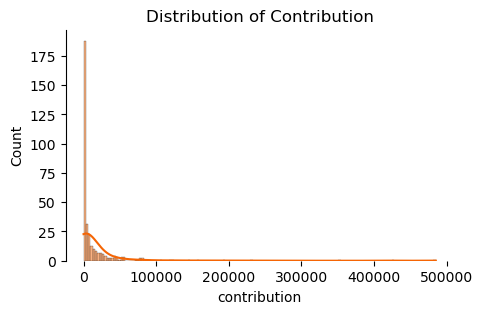

In [149]:
# Distribution of the dependent variable
plt.figure(figsize=(5, 3))
sns.histplot(df_guild['contribution'], kde=True, color=nw_clr_single)
plt.title('Distribution of Contribution')
sns.despine(bottom=True)

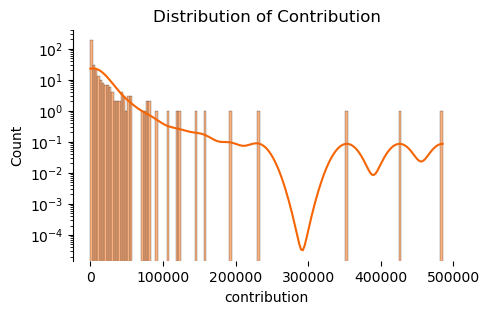

In [150]:
# Distribution of the dependent variable
plt.figure(figsize=(5, 3))
sns.histplot(df_guild['contribution'], kde=True, color=nw_clr_single)
plt.title('Distribution of Contribution')
plt.yscale('log')
sns.despine(bottom=True)

In [151]:
df_guild['contribution'].describe([.90,.95,.99,.999])

count      334.00000
mean     15624.63174
std      47331.59043
min          0.00000
50%       1875.00000
90%      37609.70000
95%      61466.90000
99%     217474.50000
99.9%   465409.77500
max     485165.00000
Name: contribution, dtype: float64

In [152]:
df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution'].describe([.90,.95,.99,.999])

count      295.00000
mean      9551.32203
std      19268.11865
min          0.00000
50%       1283.00000
90%      28157.60000
95%      50412.50000
99%      92841.74000
99.9%   122099.27800
max     122941.00000
Name: contribution, dtype: float64

In [153]:
zero_proportion = (df_guild['contribution'] == 0).mean()
print(f"Proportion of zeros: {zero_proportion:.2f}")

Proportion of zeros: 0.34


In [154]:
df_guild['contribution'].agg(['mean','median','std'])

mean     15624.63174
median    1875.00000
std      47331.59043
Name: contribution, dtype: float64

In [155]:
df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution'].agg(['mean','median','std'])

mean      9551.32203
median    1283.00000
std      19268.11865
Name: contribution, dtype: float64

In [156]:
variance_mean_ratio = np.var(df_guild['contribution']) / np.mean(df_guild['contribution'])
print(f"Variance to mean ratio (outliers incl.): {variance_mean_ratio:,.2f}")

Variance to mean ratio (outliers incl.): 142,951.98


In [157]:
variance_mean_ratio = np.var(df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution']) / np.mean(df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution'])
print(f"Variance to mean ratio (outliers excl.): {variance_mean_ratio:,.2f}")

Variance to mean ratio (outliers excl.): 38,738.29


In [158]:
log_contributions = np.log1p(df_guild['contribution'])
variance_mean_ratio_logy = np.var(log_contributions) / np.mean(log_contributions)
print(f"Variance to mean ratio of log-transformed data: {variance_mean_ratio_logy:.2f}")

Variance to mean ratio of log-transformed data: 3.45


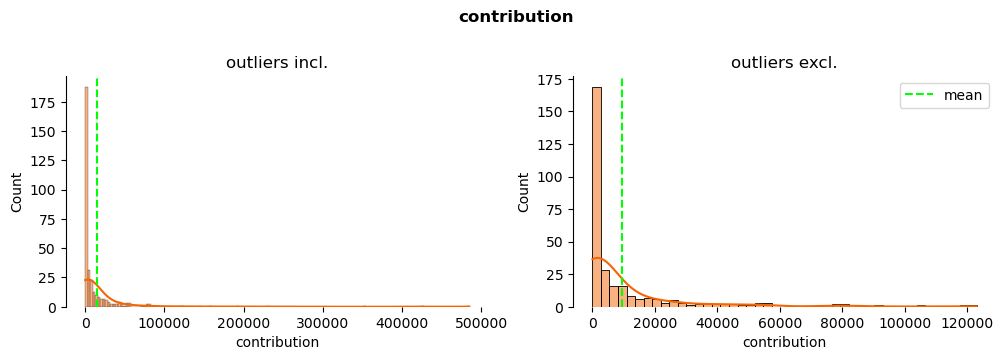

In [159]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3))
plt.suptitle('contribution', fontweight='bold',y=1.1)

sns.histplot(df_guild['contribution'], kde=True, color=nw_clr_single, ax=ax1).set_title('outliers incl.')
ax1.axvline(df_guild['contribution'].mean(), color='lime', ls='--').set_label('mean')

sns.histplot(df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution'], kde=True, color=nw_clr_single, ax=ax2).set_title('outliers excl.')
ax2.axvline(df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution'].mean(), color='lime', ls='--').set_label('mean')

plt.legend()
sns.despine(bottom=True)

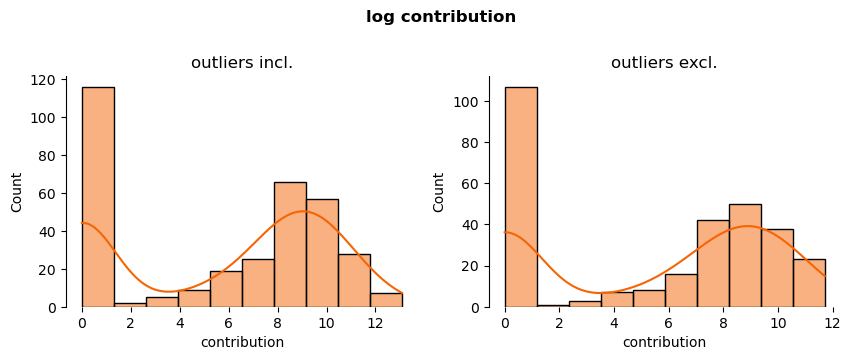

In [160]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 3))
plt.suptitle('log contribution', fontweight='bold',y=1.1)

sns.histplot(np.log1p(df_guild['contribution']), kde=True, color=nw_clr_single, ax=ax1).set_title('outliers incl.')

sns.histplot(np.log1p(df_guild[~df_guild['account'].isin(_contrib_outliers_acc)]['contribution']), kde=True, color=nw_clr_single, ax=ax2).set_title('outliers excl.')

sns.despine(bottom=True)

In [161]:
[np.median(rank) for name,rank in df_guild.groupby('guild_rank')['contribution']]

[0.0, 331.0, 455.0, 1216.0, 7591.0, 81.0, 11729.5]

In [162]:
[np.median(rank) for name,rank in df_guild[~df_guild['account'].isin(_contrib_outliers_acc)].groupby('guild_rank')['contribution']]

[0.0, 331.0, 455.0, 1180.0, 4373.0, 1232.0, 13100.0]

In [163]:
# Coefficient of Variation of contribution within guild ranks comparison
print('CV of contribution among guild ranks:')
for name, group in df_guild.groupby('guild_rank'):
    cv = np.std(group['contribution'].values)/(group['contribution'].values).mean()
    print(name, np.round(cv,2))

CV of contribution among guild ranks:
1 3.05
2 2.18
3 2.07
4 3.48
5 2.15
6 3.36
7 1.52


Ranks 7 has the least fluctuations, however the number of players there is low as well.

In [164]:
# Homogenity of variance (Levene by default), alpha=0.05
pg.homoscedasticity(df_guild, dv='contribution', group='guild_rank')

W    pval  equal_var
levene 1.72295 0.11492       True

Test for homogenity of variance shows p-value equal to ~0.1, which means that we fail to reject the null hypothesis of equal variances.

### Ordinal Logistic Regression
This type of regression wass chosen to respect the guild ranks order.

In [165]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [166]:
cat_type = pd.CategoricalDtype(categories=[1,2,3,4,5,6,7], ordered=True)

df_guild['guild_rank'] = pd.Series(df_guild['guild_rank']).astype(cat_type)

df_guild.head()

character         account character_class guild_rank  contribution  \
0          oSwowo  @@2@2#73ncr3o@           Rogue          6        485165   
1   RrRdaekereRRa     ni49an@n9@n          Cleric          4        425840   
2          eBDrBr    ome@1@9eram6       Barbarian          5        353118   
3  an anr'V aaEnk        @roo@s@b           Rogue          5        230163   
4     crcriritHrr    hiyieeeih@eh         Fighter          7        191713   

     last_active_date  days_inactive  non_zero_contribution  
0 2021-12-28 09:50:03              0                      1  
1 2021-12-27 09:16:11              1                      1  
2 2021-12-28 10:38:05              0                      1  
3 2021-12-23 11:53:50              5                      1  
4 2021-09-29 05:00:40             90                      1

In [167]:
 df_guild['guild_rank'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7], ordered=True, categories_dtype=int64)

In [168]:
model_log = OrderedModel(
    df_guild['non_zero_contribution'],
    df_guild['guild_rank'],
    distr='logit'
)

results_log = model_log.fit(method='bfgs', disp=False)

print(results_log.summary())

                               OrderedModel Results                              
Dep. Variable:     non_zero_contribution   Log-Likelihood:                -204.23
Model:                      OrderedModel   AIC:                             412.5
Method:               Maximum Likelihood   BIC:                             420.1
Date:                   Mon, 29 Jul 2024                                         
Time:                           21:46:40                                         
No. Observations:                    334                                         
Df Residuals:                        332                                         
Df Model:                              1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
guild_rank     0.3308      0.078      4.233      0.000       0.178       0.484
0/1            0.6295    

In [169]:
round(np.exp(0.3308),2)

1.39

Regression analysis reveals a significant relationship between guild rank and the likelihood of having non-zero contributions. 

The Ordinal Logistic Regression model results show that for each increase in guild rank, the odds of a member having a non-zero contribution increase by 39% (p < 0.001). Odds are not a probability!

In [170]:
predicted_probs = results_log.predict()
print(predicted_probs.shape)
predicted_probs[0]

(334, 2)


array([0.20496598, 0.79503402])

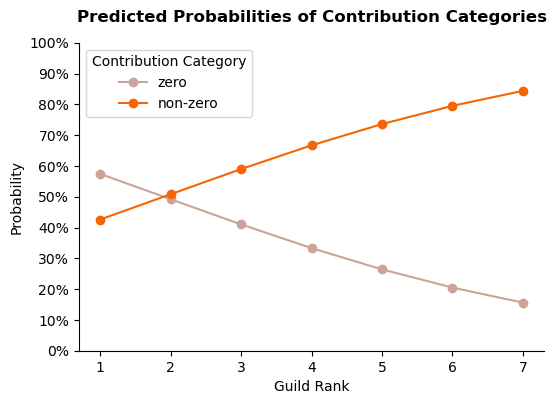

In [171]:
from matplotlib.ticker import FuncFormatter

# Function to format y-ticks as percentages
def percent_formatter(x, pos):
    return f'{x * 100:.0f}%'

plt.figure(figsize=(6, 4))

colors = [nw_clr_single_greyed,nw_clr_single]
categories = ['zero', 'non-zero']
unique_ranks = sorted(df_guild['guild_rank'].unique())

for i, category in enumerate(categories):
    mean_probs = [predicted_probs[df_guild['guild_rank'] == rank, i].mean() for rank in unique_ranks]
    plt.plot(unique_ranks, mean_probs, label=category, marker='o', color=colors[i])

plt.ylim(0, 1)
plt.yticks([i / 10.0 for i in range(11)])

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.xticks(unique_ranks)

plt.title('Predicted Probabilities of Contribution Categories', pad=15, fontweight='bold')
plt.xlabel('Guild Rank')
plt.ylabel('Probability')
plt.legend(title='Contribution Category')

sns.despine()

In [172]:
mean_probs = [predicted_probs[df_guild['guild_rank'] == rank, 1].mean() for rank in unique_ranks]
mean_probs

[0.42589404766864775,
 0.5080516760215174,
 0.5897766990510594,
 0.6668284277761481,
 0.7358886547893676,
 0.7950340211939726,
 0.8437466775121227]

In [173]:
for rank, prob in zip(unique_ranks, mean_probs):
    print(f"Guild Rank {rank}: {prob:.2%} probability of non-zero contribution")

Guild Rank 1: 42.59% probability of non-zero contribution
Guild Rank 2: 50.81% probability of non-zero contribution
Guild Rank 3: 58.98% probability of non-zero contribution
Guild Rank 4: 66.68% probability of non-zero contribution
Guild Rank 5: 73.59% probability of non-zero contribution
Guild Rank 6: 79.50% probability of non-zero contribution
Guild Rank 7: 84.37% probability of non-zero contribution


- At Guild Rank 1, a member has approximately a 43% chance of making a non-zero contribution.
- This increases to about 51% at Guild Rank 2.
- By Guild Rank 5, the probability rises to around 74%.
- At the highest Guild Rank of 7, the chance of a non-zero contribution is about 84%.

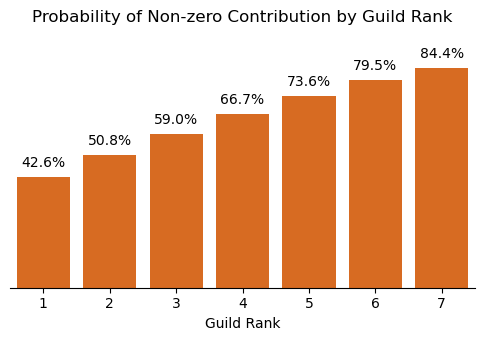

In [174]:
fig, ax = plt.subplots(figsize=(6, 3))
s = sns.barplot(
    ax=ax,
    x=unique_ranks,
    y=mean_probs,
    color=nw_clr_single
)

_bar_vals = [str(p)+'%' for p in np.round(s.containers[0].datavalues*100,1)]
s.bar_label(s.containers[0], labels=_bar_vals, padding=5)

plt.ticklabel_format(style='plain', axis='y')

plt.title('Probability of Non-zero Contribution by Guild Rank', pad=25)
plt.xlabel('Guild Rank')
plt.ylabel('Probability of Non-zero Contribution')

ax.set(ylabel=None, yticks=[])

sns.despine(left=True)